# Clasificación de Estatus de Clientes - Shimoku

## Librerias

In [65]:
# general
import numpy as np
import pandas as pd
import re
import os
import joblib
import pandas as pd
import random
import scipy.stats as stats
import pylab
import itertools

# funciones
from funciones.data_exploration import explore
from funciones.feature_cleaning import missing_data, outlier, rare_values
from funciones.feature_cleaning import missing_data as ms
from funciones.feature_cleaning import outlier as ot
from funciones.feature_cleaning import rare_values as ra
from funciones.feature_engineering import discretization as dc
from funciones.feature_engineering import discretization, encoding, transformation
from funciones.feature_selection import embedded_method, feature_shuffle, filter_method, hybrid


# visualización
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import warn
from pandas.plotting import scatter_matrix
plt.style.use('seaborn-colorblind')
#from data_exploration import explore


# preprocesamiento
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif,chi2
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder


# Aprendizaje No Supervisado
from sklearn.decomposition import PCA, KernelPCA, SparsePCA, FactorAnalysis
from sklearn.cluster import KMeans, SpectralClustering, Birch, BisectingKMeans
from sklearn.manifold import TSNE, Isomap
from sklearn.discriminant_analysis import  LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis


# ML sklearn
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
import xgboost
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier, LGBMModel
from catboost import CatBoostClassifier


# metricas de evaluacion
from sklearn.metrics import make_scorer, confusion_matrix  # matriz de confusion 
from sklearn.metrics import classification_report # reporte de clasificación

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # clasificación binaria
from sklearn.metrics import average_precision_score

from sklearn.metrics import balanced_accuracy_score, auc, roc_curve, roc_auc_score, RocCurveDisplay # clasificación multi-class
from sklearn.metrics import cohen_kappa_score, hinge_loss, matthews_corrcoef, top_k_accuracy_score


from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay # clasificación multilabel
from sklearn.metrics import fbeta_score, zero_one_loss, hamming_loss, jaccard_score, log_loss
from sklearn.metrics import coverage_error, label_ranking_average_precision_score, label_ranking_loss 

# autoML H2O
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator 
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.grid.grid_search import H2OGridSearch
# crear cluster de h2o
h2o.init()


# autoML TPOT
from tpot import TPOTClassifier


# ML pipelines
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel


from sklearn import set_config

import shap

Checking whether there is an H2O instance running at http://localhost:54321.

C:\Users\dfoso\AppData\Local\Temp\ipykernel_11416\4015232047.py:29: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


 connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


--------------------------  -----------------------------
H2O_cluster_uptime:         32 mins 45 secs
H2O_cluster_timezone:       America/Bogota
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.42.0.3
H2O_cluster_version_age:    3 months and 20 days
H2O_cluster_name:           H2O_from_python_dfoso_2t528x
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    125.6 Mb
H2O_cluster_total_cores:    4
H2O_cluster_allowed_cores:  4
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.11.4 final
--------------------------  -----------------------------

## Bases de datos

In [442]:
# cargar bases de datos
data1 = pd.read_csv('data/leads.csv')
data2 = pd.read_csv('data/offers.csv')


In [443]:
data1

Id       First Name          Use Case    Source     Status  \
0      23okrabh              NaN  Corporate Events   Inbound  Nurturing   
1           NaN  Taylor1 Harris1               NaN   Inbound  Discarded   
2      hbzt0kp1   Alex6 Jackson3               NaN   Inbound  Nurturing   
3      velluwdq  Bailey2 Taylor6  Corporate Events   Inbound  Discarded   
4           NaN    Drew5 Wilson5  Corporate Events   Inbound  Nurturing   
...         ...              ...               ...       ...        ...   
61634  lpb8obv3              NaN  Corporate Events  Outbound        New   
61635  mzcq31rg              NaN               NaN  Outbound        New   
61636  2ajg0z5w              NaN  Corporate Events  Outbound        New   
61637  k6wq2pi9              NaN               NaN  Outbound        New   
61638  vez26u63              NaN  Corporate Events   Inbound        New   

      Discarded/Nurturing Reason    Acquisition Campaign Created Date  \
0                        Not Fit                     NaN   2018-05-26   
1                    Not feeling  Event Management Guide   2018-10-17   
2                     Competitor                     NaN   2019-03-29   
3                     Not Target                     NaN   2018-05-26   
4                     Competitor                     NaN   2018-10-17   
...                          ...                     ...          ...   
61634                        NaN             Digital kit   2020-10-27   
61635                        NaN                 ArtFair   2020-10-27   
61636                        NaN                     NaN   2020-10-27   
61637                        NaN          VirtualMeetups   2020-10-27   
61638                        NaN                     NaN   2020-10-27   

       Converted       City  
0              0    Chicago  
1              0     Denver  
2              0     Denver  
3              0        NaN  
4              0        NaN  
...          ...        ...  
61634          0    Phoenix  
61635          0        NaN  
61636          0        NaN  
61637          0  Charlotte  
61638          0        NaN  

[61639 rows x 10 columns]

In [444]:
data2

Id              Use Case       Status Created Date  Close Date  \
0     doqyhjtv  Educational Seminars   Closed Won   2019-11-17  2019-11-17   
1          NaN         Sports Events  Closed Lost   2019-11-24  2019-11-25   
2          NaN         Sports Events  Closed Lost   2019-11-24  2019-11-25   
3     cturqi48      Corporate Events   Closed Won   2019-05-07  2019-05-07   
4          NaN         Sports Events  Closed Lost   2019-11-17  2019-11-25   
...        ...                   ...          ...          ...         ...   
6125       NaN      Corporate Events  Closed Lost   2019-05-20  2019-05-21   
6126       NaN      Wedding Planning   Closed Won   2019-05-20  2019-05-20   
6127  88tre7ve      Corporate Events  Closed Lost   2019-05-20  2019-05-20   
6128  2d15fo90      Corporate Events  Closed Lost   2019-05-20  2019-05-26   
6129  9k6zoun6         Sports Events   Closed Won   2019-05-20  2019-05-21   

       Price    Discount code               Pain     Loss Reason  
0      300.0       SAVEMORE50         operations             NaN  
1      150.0              NaN         operations           price  
2      768.0      HALFYEAR20G         operations     no response  
3      240.0  DISCOUNT50POWER  financial control             NaN  
4      240.0     SAVEMONTH50G  financial control     no response  
...      ...              ...                ...             ...  
6125   120.0              NaN         operations           price  
6126     NaN              NaN                NaN             NaN  
6127   768.0  2SEMESTERS20OFF         operations     no response  
6128  1344.0              NaN         operations  no product fit  
6129   240.0     SAVEMONTH50G         operations             NaN  

[6130 rows x 9 columns]

In [445]:
data1['Status'].value_counts()

Nurturing    24060
Discarded    20478
Qualified     5828
New           3493
Called        2976
Engaged       1817
Linkedin       984
Contacted      980
Meeting        576
Email          394
Recicled        41
Call            12
Name: Status, dtype: int64

In [446]:
data1.columns

Index(['Id', 'First Name', 'Use Case', 'Source', 'Status',
       'Discarded/Nurturing Reason', 'Acquisition Campaign', 'Created Date',
       'Converted', 'City'],
      dtype='object')

In [447]:
data2.columns

Index(['Id', 'Use Case', 'Status', 'Created Date', 'Close Date', 'Price',
       'Discount code', 'Pain', 'Loss Reason'],
      dtype='object')

In [453]:
# unir (merge) bases de datos por columna Id
data = pd.merge(data1, data2, how='right', on=['Id','Use Case','Status','Created Date'])
data

Id First Name              Use Case Source       Status  \
0     doqyhjtv        NaN  Educational Seminars    NaN   Closed Won   
1          NaN        NaN         Sports Events    NaN  Closed Lost   
2          NaN        NaN         Sports Events    NaN  Closed Lost   
3     cturqi48        NaN      Corporate Events    NaN   Closed Won   
4          NaN        NaN         Sports Events    NaN  Closed Lost   
...        ...        ...                   ...    ...          ...   
6125       NaN        NaN      Corporate Events    NaN  Closed Lost   
6126       NaN        NaN      Wedding Planning    NaN   Closed Won   
6127  88tre7ve        NaN      Corporate Events    NaN  Closed Lost   
6128  2d15fo90        NaN      Corporate Events    NaN  Closed Lost   
6129  9k6zoun6        NaN         Sports Events    NaN   Closed Won   

     Discarded/Nurturing Reason Acquisition Campaign Created Date  Converted  \
0                           NaN                  NaN   2019-11-17        NaN   
1                           NaN                  NaN   2019-11-24        NaN   
2                           NaN                  NaN   2019-11-24        NaN   
3                           NaN                  NaN   2019-05-07        NaN   
4                           NaN                  NaN   2019-11-17        NaN   
...                         ...                  ...          ...        ...   
6125                        NaN                  NaN   2019-05-20        NaN   
6126                        NaN                  NaN   2019-05-20        NaN   
6127                        NaN                  NaN   2019-05-20        NaN   
6128                        NaN                  NaN   2019-05-20        NaN   
6129                        NaN                  NaN   2019-05-20        NaN   

     City  Close Date   Price    Discount code               Pain  \
0     NaN  2019-11-17   300.0       SAVEMORE50         operations   
1     NaN  2019-11-25   150.0              NaN         operations   
2     NaN  2019-11-25   768.0      HALFYEAR20G         operations   
3     NaN  2019-05-07   240.0  DISCOUNT50POWER  financial control   
4     NaN  2019-11-25   240.0     SAVEMONTH50G  financial control   
...   ...         ...     ...              ...                ...   
6125  NaN  2019-05-21   120.0              NaN         operations   
6126  NaN  2019-05-20     NaN              NaN                NaN   
6127  NaN  2019-05-20   768.0  2SEMESTERS20OFF         operations   
6128  NaN  2019-05-26  1344.0              NaN         operations   
6129  NaN  2019-05-21   240.0     SAVEMONTH50G         operations   

         Loss Reason  
0                NaN  
1              price  
2        no response  
3                NaN  
4        no response  
...              ...  
6125           price  
6126             NaN  
6127     no response  
6128  no product fit  
6129             NaN  

[6130 rows x 15 columns]

## Preprocesamiento

### Limpieza de datos

In [454]:
# calcular porcentaje de missing values y NULLs en cada columna
porcentaje_missing = data.isna().mean() * 100
porcentaje_null = data.isna().mean() * 100

# Sort the variables by missing percentage in descending order
porcentaje_missing.sort_values(ascending=False, inplace=True)
porcentaje_null.sort_values(ascending=False, inplace=True)

# ver variables por porcentaje de NA/NULL
print('porcentaje missing NA',porcentaje_missing)
print('porcentaje NULL NULL',porcentaje_null)

porcentaje missing NA First Name                    100.000000
Source                        100.000000
Discarded/Nurturing Reason    100.000000
Acquisition Campaign          100.000000
Converted                     100.000000
City                          100.000000
Loss Reason                    61.435563
Discount code                  27.716150
Id                             19.053834
Pain                           14.176183
Price                           5.954323
Use Case                        0.603589
Status                          0.000000
Created Date                    0.000000
Close Date                      0.000000
dtype: float64
porcentaje NULL NULL First Name                    100.000000
Source                        100.000000
Discarded/Nurturing Reason    100.000000
Acquisition Campaign          100.000000
Converted                     100.000000
City                          100.000000
Loss Reason                    61.435563
Discount code                  27.716150

### Imputación por Umbral

In [456]:
# quitar columnas (variables) con mas de 20% de NA
data.dropna(axis=1,inplace=True,thresh=0.8*len(data))
data

### quedan 7 columnas con menos de 20% de NAs 

Id              Use Case       Status Created Date  Close Date  \
0     doqyhjtv  Educational Seminars   Closed Won   2019-11-17  2019-11-17   
1          NaN         Sports Events  Closed Lost   2019-11-24  2019-11-25   
2          NaN         Sports Events  Closed Lost   2019-11-24  2019-11-25   
3     cturqi48      Corporate Events   Closed Won   2019-05-07  2019-05-07   
4          NaN         Sports Events  Closed Lost   2019-11-17  2019-11-25   
...        ...                   ...          ...          ...         ...   
6125       NaN      Corporate Events  Closed Lost   2019-05-20  2019-05-21   
6126       NaN      Wedding Planning   Closed Won   2019-05-20  2019-05-20   
6127  88tre7ve      Corporate Events  Closed Lost   2019-05-20  2019-05-20   
6128  2d15fo90      Corporate Events  Closed Lost   2019-05-20  2019-05-26   
6129  9k6zoun6         Sports Events   Closed Won   2019-05-20  2019-05-21   

       Price               Pain  
0      300.0         operations  
1      150.0         operations  
2      768.0         operations  
3      240.0  financial control  
4      240.0  financial control  
...      ...                ...  
6125   120.0         operations  
6126     NaN                NaN  
6127   768.0         operations  
6128  1344.0         operations  
6129   240.0         operations  

[6130 rows x 7 columns]

In [457]:
# máscara de missing values
missing_mask = data.isnull()
missing_mask

Id  Use Case  Status  Created Date  Close Date  Price   Pain
0     False     False   False         False       False  False  False
1      True     False   False         False       False  False  False
2      True     False   False         False       False  False  False
3     False     False   False         False       False  False  False
4      True     False   False         False       False  False  False
...     ...       ...     ...           ...         ...    ...    ...
6125   True     False   False         False       False  False  False
6126   True     False   False         False       False   True   True
6127  False     False   False         False       False  False  False
6128  False     False   False         False       False  False  False
6129  False     False   False         False       False  False  False

[6130 rows x 7 columns]

In [460]:
# extraer tipos de variables
numeric_columns = data.select_dtypes(include=['float16', 'float32','float64'])
integer_columns = data.select_dtypes(include=['int8', 'int16', 'int32', 'int64'])
categorical_columns = data.select_dtypes(include=['object'])

data_num = data.select_dtypes(exclude=['object'])
data_cate = data.select_dtypes(include=['object'])


In [461]:
num = numeric_columns.columns.tolist()
cate = ['Use Case','Pain']
date = ['Created Date', 'Close Date']

### Imputación Simple por Promedio  (Price)

In [462]:
# crear Imputador Simple 
mean = data['Price'].mean()
data['Price'].fillna(mean, inplace=True)


### Imputación Simple por Moda 

In [463]:
# Create the imputer object
imputer = SimpleImputer(strategy="most_frequent", missing_values=np.nan)

# Fit the imputer on the selected columns
imputer.fit(data[cate])

# Transform the dataframe with imputed values
data[cate] = imputer.transform(data[cate])


### Transformar series de tiempo

In [464]:
data['Created Date'] = pd.to_datetime(data['Created Date'])

# Extract year, month, and day as separate columns
data['create_date_year'] = data['Created Date'].dt.year
data['create_date_month'] = data['Created Date'].dt.month
data['create_date_day'] = data['Created Date'].dt.day

data.drop('Created Date', axis=1, inplace=True)


In [465]:
data['Close Date'] = pd.to_datetime(data['Close Date'])

# Extract year, month, and day as separate columns
data['close_date_year'] = data['Close Date'].dt.year
data['close_date_month'] = data['Close Date'].dt.month
data['close_date_day'] = data['Close Date'].dt.day

data.drop('Close Date', axis=1, inplace=True)

In [466]:
# quitar columna ID (no aporta al modelo)
data.drop('Id', axis=1, inplace=True)

### Crear variables y-target Clasificación Multiclase

In [467]:
x = data.drop(['Status'], axis=1)
y = data['Status']


In [468]:
x

Use Case        Price               Pain  create_date_year  \
0     Educational Seminars   300.000000         operations              2019   
1            Sports Events   150.000000         operations              2019   
2            Sports Events   768.000000         operations              2019   
3         Corporate Events   240.000000  financial control              2019   
4            Sports Events   240.000000  financial control              2019   
...                    ...          ...                ...               ...   
6125      Corporate Events   120.000000         operations              2019   
6126      Wedding Planning  1303.754033         operations              2019   
6127      Corporate Events   768.000000         operations              2019   
6128      Corporate Events  1344.000000         operations              2019   
6129         Sports Events   240.000000         operations              2019   

      create_date_month  create_date_day  close_date_year  close_date_month  \
0                    11               17             2019                11   
1                    11               24             2019                11   
2                    11               24             2019                11   
3                     5                7             2019                 5   
4                    11               17             2019                11   
...                 ...              ...              ...               ...   
6125                  5               20             2019                 5   
6126                  5               20             2019                 5   
6127                  5               20             2019                 5   
6128                  5               20             2019                 5   
6129                  5               20             2019                 5   

      close_date_day  
0                 17  
1                 25  
2                 25  
3                  7  
4                 25  
...              ...  
6125              21  
6126              20  
6127              20  
6128              26  
6129              21  

[6130 rows x 9 columns]

In [469]:
y

0        Closed Won
1       Closed Lost
2       Closed Lost
3        Closed Won
4       Closed Lost
           ...     
6125    Closed Lost
6126     Closed Won
6127    Closed Lost
6128    Closed Lost
6129     Closed Won
Name: Status, Length: 6130, dtype: object

### Dividir base de datos en datos de entrenamiento y datos de validación

In [470]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x, y, test_size=0.2, random_state=1, stratify=y)

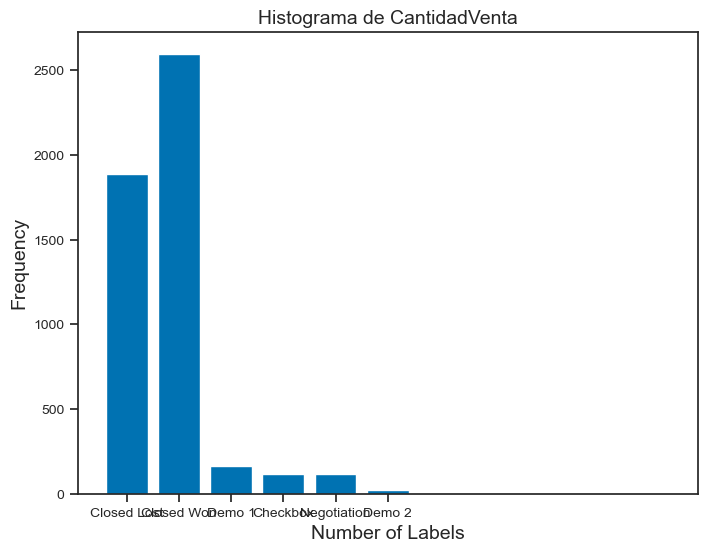

In [471]:
# Histogram
plt.figure(figsize=(8, 6))
plt.hist(y_train1, bins=range(12), align='left', rwidth=0.8)
plt.xlabel('Number of Labels')
plt.ylabel('Frequency')
plt.title('Histograma de CantidadVenta')
plt.show()

### Codificación

In [472]:
# one-hot encoding [0-1]
# crear columnas [0-1] para variables categoricas
x_train1 = pd.get_dummies(x_train1, drop_first=True)
x_test1 = pd.get_dummies(x_test1, drop_first=True)

x_train1

Price  create_date_year  create_date_month  create_date_day  \
1297    200.0              2018                  7                9   
5870   1344.0              2019                  4               17   
4539    360.0              2018                 11                6   
293     324.0              2019                 10                6   
3879    768.0              2018                 11               13   
...       ...               ...                ...              ...   
1029  14870.0              2018                  9                2   
4286    240.0              2018                  8               22   
4356    300.0              2019                  1               23   
2719    768.0              2019                 10               20   
734     768.0              2019                 11               20   

      close_date_year  close_date_month  close_date_day  \
1297             2018                 7              10   
5870             2019                 4              20   
4539             2018                11              25   
293              2019                11               9   
3879             2018                11              13   
...               ...               ...             ...   
1029             2018                 9               2   
4286             2018                 8              25   
4356             2019                 1              23   
2719             2019                10              26   
734              2019                11              20   

      Use Case_Corporate Events  Use Case_Educational Seminars  \
1297                          1                              0   
5870                          0                              0   
4539                          0                              1   
293                           1                              0   
3879                          1                              0   
...                         ...                            ...   
1029                          0                              1   
4286                          1                              0   
4356                          0                              0   
2719                          1                              0   
734                           0                              1   

      Use Case_Sports Events  Use Case_Wedding Planning  Pain_operations  \
1297                       0                          0                1   
5870                       1                          0                1   
4539                       0                          0                0   
293                        0                          0                1   
3879                       0                          0                1   
...                      ...                        ...              ...   
1029                       0                          0                0   
4286                       0                          0                1   
4356                       1                          0                1   
2719                       0                          0                1   
734                        0                          0                0   

      Pain_quality of delivery  Pain_time saving  
1297                         0                 0  
5870                         0                 0  
4539                         0                 0  
293                          0                 0  
3879                         0                 0  
...                        ...               ...  
1029                         1                 0  
4286                         0                 0  
4356                         0                 0  
2719                         0                 0  
734                          0                 0  

[4904 rows x 14 columns]

### Estandarización

In [473]:
# crear escalador Estandar
# ajustar escalador con datos de entrenamiento
escalador = StandardScaler()

# ajustar escalador con DataFrame no-binario(float)
escalador.fit(x_train1[num])

# estandarizar datos de entrenamiento y prueba
x_train1[num] = escalador.transform(x_train1[num])
x_test1[num] = escalador.transform(x_test1[num])



In [478]:
x_train1.drop('Use Case_Corporate Events', axis=1, inplace=True)

In [479]:
x_train1

Price  create_date_year  create_date_month  create_date_day  \
1297 -0.117744              2018                  7                9   
5870  0.006201              2019                  4               17   
4539 -0.100409              2018                 11                6   
293  -0.104310              2019                 10                6   
3879 -0.056205              2018                 11               13   
...        ...               ...                ...              ...   
1029  1.471660              2018                  9                2   
4286 -0.113410              2018                  8               22   
4356 -0.106910              2019                  1               23   
2719 -0.056205              2019                 10               20   
734  -0.056205              2019                 11               20   

      close_date_year  close_date_month  close_date_day  \
1297             2018                 7              10   
5870             2019                 4              20   
4539             2018                11              25   
293              2019                11               9   
3879             2018                11              13   
...               ...               ...             ...   
1029             2018                 9               2   
4286             2018                 8              25   
4356             2019                 1              23   
2719             2019                10              26   
734              2019                11              20   

      Use Case_Educational Seminars  Use Case_Sports Events  \
1297                              0                       0   
5870                              0                       1   
4539                              1                       0   
293                               0                       0   
3879                              0                       0   
...                             ...                     ...   
1029                              1                       0   
4286                              0                       0   
4356                              0                       1   
2719                              0                       0   
734                               1                       0   

      Use Case_Wedding Planning  Pain_operations  Pain_quality of delivery  \
1297                          0                1                         0   
5870                          0                1                         0   
4539                          0                0                         0   
293                           0                1                         0   
3879                          0                1                         0   
...                         ...              ...                       ...   
1029                          0                0                         1   
4286                          0                1                         0   
4356                          0                1                         0   
2719                          0                1                         0   
734                           0                0                         0   

      Pain_time saving  
1297                 0  
5870                 0  
4539                 0  
293                  0  
3879                 0  
...                ...  
1029                 0  
4286                 0  
4356                 0  
2719                 0  
734                  0  

[4904 rows x 13 columns]

In [480]:
x_test1

Price  create_date_year  create_date_month  create_date_day  \
1198 -0.100409              2018                  2                3   
1836 -0.100409              2019                  8                1   
5198 -0.123161              2019                  4               30   
5434  0.001841              2019                  4               23   
2158 -0.030202              2019                  9               24   
...        ...               ...                ...              ...   
5152 -0.077007              2019                  6               10   
3634 -0.100409              2018                  1                5   
2697 -0.030202              2019                 10               19   
1017 -0.074407              2018                  8               11   
2650 -0.056205              2019                  7               23   

      close_date_year  close_date_month  close_date_day  \
1198             2018                 2               3   
1836             2019                 6              25   
5198             2019                 4              30   
5434             2019                 3              18   
2158             2019                 5               5   
...               ...               ...             ...   
5152             2019                 6              10   
3634             2018                 1               5   
2697             2019                10              21   
1017             2018                 8              26   
2650             2019                 7              23   

      Use Case_Educational Seminars  Use Case_Sports Events  \
1198                              0                       0   
1836                              0                       0   
5198                              0                       0   
5434                              0                       0   
2158                              0                       0   
...                             ...                     ...   
5152                              0                       1   
3634                              0                       0   
2697                              1                       0   
1017                              0                       0   
2650                              0                       0   

      Use Case_Wedding Planning  Pain_operations  Pain_quality of delivery  \
1198                          0                1                         0   
1836                          0                0                         0   
5198                          0                1                         0   
5434                          1                1                         0   
2158                          0                1                         0   
...                         ...              ...                       ...   
5152                          0                1                         0   
3634                          0                1                         0   
2697                          0                1                         0   
1017                          0                1                         0   
2650                          0                0                         0   

      Pain_time saving  
1198                 0  
1836                 0  
5198                 0  
5434                 0  
2158                 0  
...                ...  
5152                 0  
3634                 0  
2697                 0  
1017                 0  
2650                 0  

[1226 rows x 13 columns]

In [476]:
y_train1 

1297    Closed Lost
5870    Closed Lost
4539    Closed Lost
293     Closed Lost
3879     Closed Won
           ...     
1029     Closed Won
4286    Closed Lost
4356     Closed Won
2719    Closed Lost
734      Closed Won
Name: Status, Length: 4904, dtype: object

In [477]:
y_test1

1198     Closed Won
1836    Closed Lost
5198     Closed Won
5434     Closed Won
2158     Closed Won
           ...     
5152     Closed Won
3634     Closed Won
2697     Closed Won
1017    Closed Lost
2650     Closed Won
Name: Status, Length: 1226, dtype: object

In [425]:
x_train1.columns

Index(['Price', 'create_date_year', 'create_date_month', 'create_date_day',
       'close_date_year', 'close_date_month', 'close_date_day',
       'Use Case_Educational Seminars', 'Use Case_Sports Events',
       'Use Case_Wedding Planning', 'Pain_operations',
       'Pain_quality of delivery', 'Pain_time saving'],
      dtype='object')

In [426]:
x_test1.columns

Index(['Price', 'create_date_year', 'create_date_month', 'create_date_day',
       'close_date_year', 'close_date_month', 'close_date_day',
       'Use Case_Educational Seminars', 'Use Case_Sports Events',
       'Use Case_Wedding Planning', 'Pain_operations',
       'Pain_quality of delivery', 'Pain_time saving'],
      dtype='object')

### Guardar bases de datos

In [481]:
# guardar bases de datos
# datos de entrenamiento
x_train1.to_csv('data/shimoku/x_train1preprocess.csv', index=False)
y_train1.to_csv('data/shimoku/y_train1preprocess.csv', index=False)

# datos de prueba
x_test1.to_csv('data/shimoku/x_test1preprocess.csv', index=False)
y_test1.to_csv('data/shimoku/y_test1preprocess.csv', index=False)


## EDA

In [482]:
# cargar datos de entrenamiento 
x_train1 = pd.read_csv('data/shimoku/x_train1preprocess.csv')
y_train1 = pd.read_csv('data/shimoku/y_train1preprocess.csv')

# cargar datos de prueba
x_test1 = pd.read_csv('data/shimoku/x_test1preprocess.csv')
y_test1 = pd.read_csv('data/shimoku/y_test1preprocess.csv')

In [239]:
# crear base de datos de entrenamiento full
full_train1 = x_train1.copy()
full_train1['y_target'] = y_train1
full_train1


Price  create_date_year  create_date_month  create_date_day  \
0       200.0              2018                  7                9   
1      1344.0              2019                  4               17   
2       360.0              2018                 11                6   
3       324.0              2019                 10                6   
4       768.0              2018                 11               13   
...       ...               ...                ...              ...   
4899  14870.0              2018                  9                2   
4900    240.0              2018                  8               22   
4901    300.0              2019                  1               23   
4902    768.0              2019                 10               20   
4903    768.0              2019                 11               20   

      close_date_year  close_date_month  close_date_day  \
0                2018                 7              10   
1                2019                 4              20   
2                2018                11              25   
3                2019                11               9   
4                2018                11              13   
...               ...               ...             ...   
4899             2018                 9               2   
4900             2018                 8              25   
4901             2019                 1              23   
4902             2019                10              26   
4903             2019                11              20   

      Use Case_Corporate Events  Use Case_Educational Seminars  \
0                             1                              0   
1                             0                              0   
2                             0                              1   
3                             1                              0   
4                             1                              0   
...                         ...                            ...   
4899                          0                              1   
4900                          1                              0   
4901                          0                              0   
4902                          1                              0   
4903                          0                              1   

      Use Case_Sports Events  Use Case_Wedding Planning  Pain_operations  \
0                          0                          0                1   
1                          1                          0                1   
2                          0                          0                0   
3                          0                          0                1   
4                          0                          0                1   
...                      ...                        ...              ...   
4899                       0                          0                0   
4900                       0                          0                1   
4901                       1                          0                1   
4902                       0                          0                1   
4903                       0                          0                0   

      Pain_quality of delivery  Pain_time saving     y_target  
0                            0                 0  Closed Lost  
1                            0                 0  Closed Lost  
2                            0                 0  Closed Lost  
3                            0                 0  Closed Lost  
4                            0                 0   Closed Won  
...                        ...               ...          ...  
4899                         1                 0   Closed Won  
4900                         0                 0  Closed Lost  
4901                         0                 0   Closed Won  
4902                         0                 0  Closed Lost  
4903                         0      

### Análisis Descriptivo

In [240]:
full_train1.describe()

Price  create_date_year  create_date_month  create_date_day  \
count    4904.000000       4904.000000        4904.000000      4904.000000   
mean     1286.763953       2018.703100           7.099918        14.885808   
std      9230.811936          0.511287           3.312626         8.606901   
min         0.000000       2018.000000           1.000000         1.000000   
25%       240.000000       2018.000000           4.000000         7.000000   
50%       360.000000       2019.000000           7.000000        15.000000   
75%       768.000000       2019.000000          10.000000        23.000000   
max    264904.000000       2020.000000          12.000000        31.000000   

       close_date_year  close_date_month  close_date_day  \
count      4904.000000       4904.000000     4904.000000   
mean       2018.728793          7.137643       16.640701   
std           0.543310          3.404478        8.510326   
min        2013.000000          1.000000        1.000000   
25%        2018.000000          4.000000        9.000000   
50%        2019.000000          7.000000       18.000000   
75%        2019.000000         10.000000       25.000000   
max        2020.000000         12.000000       31.000000   

       Use Case_Corporate Events  Use Case_Educational Seminars  \
count                4904.000000                    4904.000000   
mean                    0.570351                       0.215946   
std                     0.495077                       0.411519   
min                     0.000000                       0.000000   
25%                     0.000000                       0.000000   
50%                     1.000000                       0.000000   
75%                     1.000000                       0.000000   
max                     1.000000                       1.000000   

       Use Case_Sports Events  Use Case_Wedding Planning  Pain_operations  \
count             4904.000000                4904.000000      4904.000000   
mean                 0.175367                   0.037928         0.681688   
std                  0.380320                   0.191042         0.465869   
min                  0.000000                   0.000000         0.000000   
25%                  0.000000                   0.000000         0.000000   
50%                  0.000000                   0.000000         1.000000   
75%                  0.000000                   0.000000         1.000000   
max                  1.000000                   1.000000         1.000000   

       Pain_quality of delivery  Pain_time saving  
count               4904.000000       4904.000000  
mean                   0.110114          0.011827  
std                    0.313064          0.108118  
min                    0.000000          0.000000  
25%                    0.000000          0.000000  
50%                    0.000000          0.000000  
75%                    0.000000          0.000000  
max                    1.000000          1.000000

In [241]:
full_train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4904 entries, 0 to 4903
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Price                          4904 non-null   float64
 1   create_date_year               4904 non-null   int64  
 2   create_date_month              4904 non-null   int64  
 3   create_date_day                4904 non-null   int64  
 4   close_date_year                4904 non-null   int64  
 5   close_date_month               4904 non-null   int64  
 6   close_date_day                 4904 non-null   int64  
 7   Use Case_Corporate Events      4904 non-null   int64  
 8   Use Case_Educational Seminars  4904 non-null   int64  
 9   Use Case_Sports Events         4904 non-null   int64  
 10  Use Case_Wedding Planning      4904 non-null   int64  
 11  Pain_operations                4904 non-null   int64  
 12  Pain_quality of delivery       4904 non-null   i

In [242]:
# proporcion por clase 
full_train1.value_counts()

Price          create_date_year  create_date_month  create_date_day  close_date_year  close_date_month  close_date_day  Use Case_Corporate Events  Use Case_Educational Seminars  Use Case_Sports Events  Use Case_Wedding Planning  Pain_operations  Pain_quality of delivery  Pain_time saving  y_target   
1303.754033    2019              5                  11               2019             5                 11              0                          0                              0                       1                          1                0                         0                 Closed Won     8
                                 4                  23               2019             3                 18              0                          0                              0                       1                          1                0                         0                 Closed Won     4
360.000000     2019              1                  2                2019           

In [247]:
# contar observaciones por clase y-target
full_train1['y_target'].value_counts()

# proporcion por clase y-target 
full_train1['y_target'].value_counts(normalize=True)



Closed Won     0.529772
Closed Lost    0.384584
Demo 1         0.034054
Negotiation    0.023858
Checkbox       0.023450
Demo 2         0.004282
Name: y_target, dtype: float64

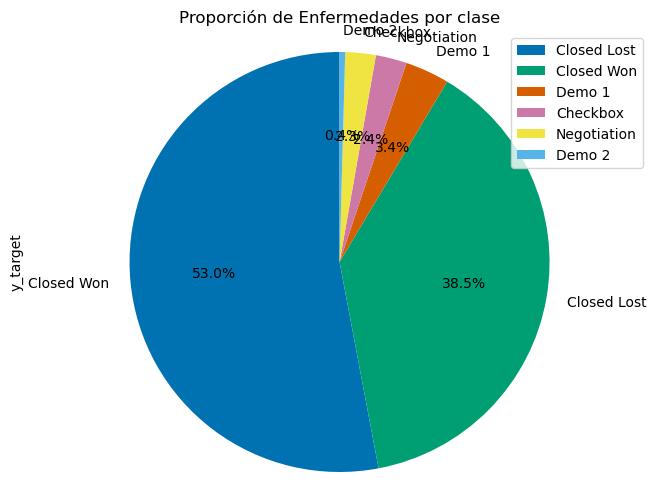

In [248]:
# calcular proporcion de clase y-target
full_train1['y_target'].value_counts()
# calcular proporcion de clases
class_proportions = full_train1['y_target'].value_counts(normalize=True)

# crear pie plot
plt.figure(figsize=(8, 6))
class_proportions.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Proporción de Enfermedades por clase')
plt.legend(labels=full_train1['y_target'].unique().tolist(), loc='best')
plt.axis('equal')

# Show the plot
plt.show()

### Técnicas de Correlación

#### Correlación de Pearson (Lineal)

In [251]:
pearson_corr = full_train1.corr(method='pearson')
pearson_corr

C:\Users\dfoso\AppData\Local\Temp\ipykernel_22644\4111783014.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pearson_corr = full_train1.corr(method='pearson')


Price  create_date_year  create_date_month  \
Price                          1.000000          0.006172          -0.020428   
create_date_year               0.006172          1.000000          -0.194662   
create_date_month             -0.020428         -0.194662           1.000000   
create_date_day                0.008314          0.271584           0.056090   
close_date_year                0.005143          0.924473          -0.127274   
close_date_month              -0.009772         -0.222461           0.697290   
close_date_day                 0.017044          0.220018           0.045123   
Use Case_Corporate Events     -0.029996         -0.121322           0.053791   
Use Case_Educational Seminars  0.012272          0.076015           0.010052   
Use Case_Sports Events         0.027669          0.016084          -0.053574   
Use Case_Wedding Planning     -0.003602          0.117398          -0.053043   
Pain_operations               -0.013946         -0.006389          -0.065555   
Pain_quality of delivery       0.042895         -0.049278           0.032852   
Pain_time saving               0.018258          0.022950           0.005242   

                               create_date_day  close_date_year  \
Price                                 0.008314         0.005143   
create_date_year                      0.271584         0.924473   
create_date_month                     0.056090        -0.127274   
create_date_day                       1.000000         0.245824   
close_date_year                       0.245824         1.000000   
close_date_month                     -0.085245        -0.310942   
close_date_day                        0.693576         0.257921   
Use Case_Corporate Events            -0.034779        -0.117101   
Use Case_Educational Seminars        -0.006914         0.093237   
Use Case_Sports Events               -0.000050         0.014054   
Use Case_Wedding Planning             0.104720         0.073578   
Pain_operations                       0.046072        -0.025265   
Pain_quality of delivery             -0.039008        -0.036630   
Pain_time saving                     -0.004028         0.019895   

                               close_date_month  close_date_day  \
Price                                 -0.009772        0.017044   
create_date_year                      -0.222461        0.220018   
create_date_month                      0.697290        0.045123   
create_date_day                       -0.085245        0.693576   
close_date_year                       -0.310942        0.257921   
close_date_month                       1.000000        0.001039   
close_date_day                         0.001039        1.000000   
Use Case_Corporate Events              0.032553       -0.065256   
Use Case_Educational Seminars          0.009497        0.063682   
Use Case_Sports Events                -0.035974       -0.001576   
Use Case_Wedding Planning             -0.031861        0.033222   
Pain_operations                       -0.066887        0.007621   
Pain_quality of delivery               0.021370       -0.020208   
Pain_time saving                       0.000009        0.007944   

                               Use Case_Corporate Events  \
Price                                          -0.029996   
create_date_year                               -0.121322   
create_date_month                               0.053791   
create_date_day                                -0.034779   
close_date_year                                -0.117101   
close_date_month                                0.032553   
close_date_day                                 -0.065256   
Use Case_Corporate Events                       1.000000   
Use Case_Educational Seminars                  -0.604664   
Use Case_Sports Events                         -0.531322   
Use Case_Wedding Planning                      -0.228766   
Pain_operations                                 0.093133   
Pain_quality of delivery                 

C:\Users\dfoso\AppData\Local\Temp\ipykernel_22644\1377960007.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(full_train1.corr(method='pearson'), annot=True, cmap='coolwarm', ax=ax)


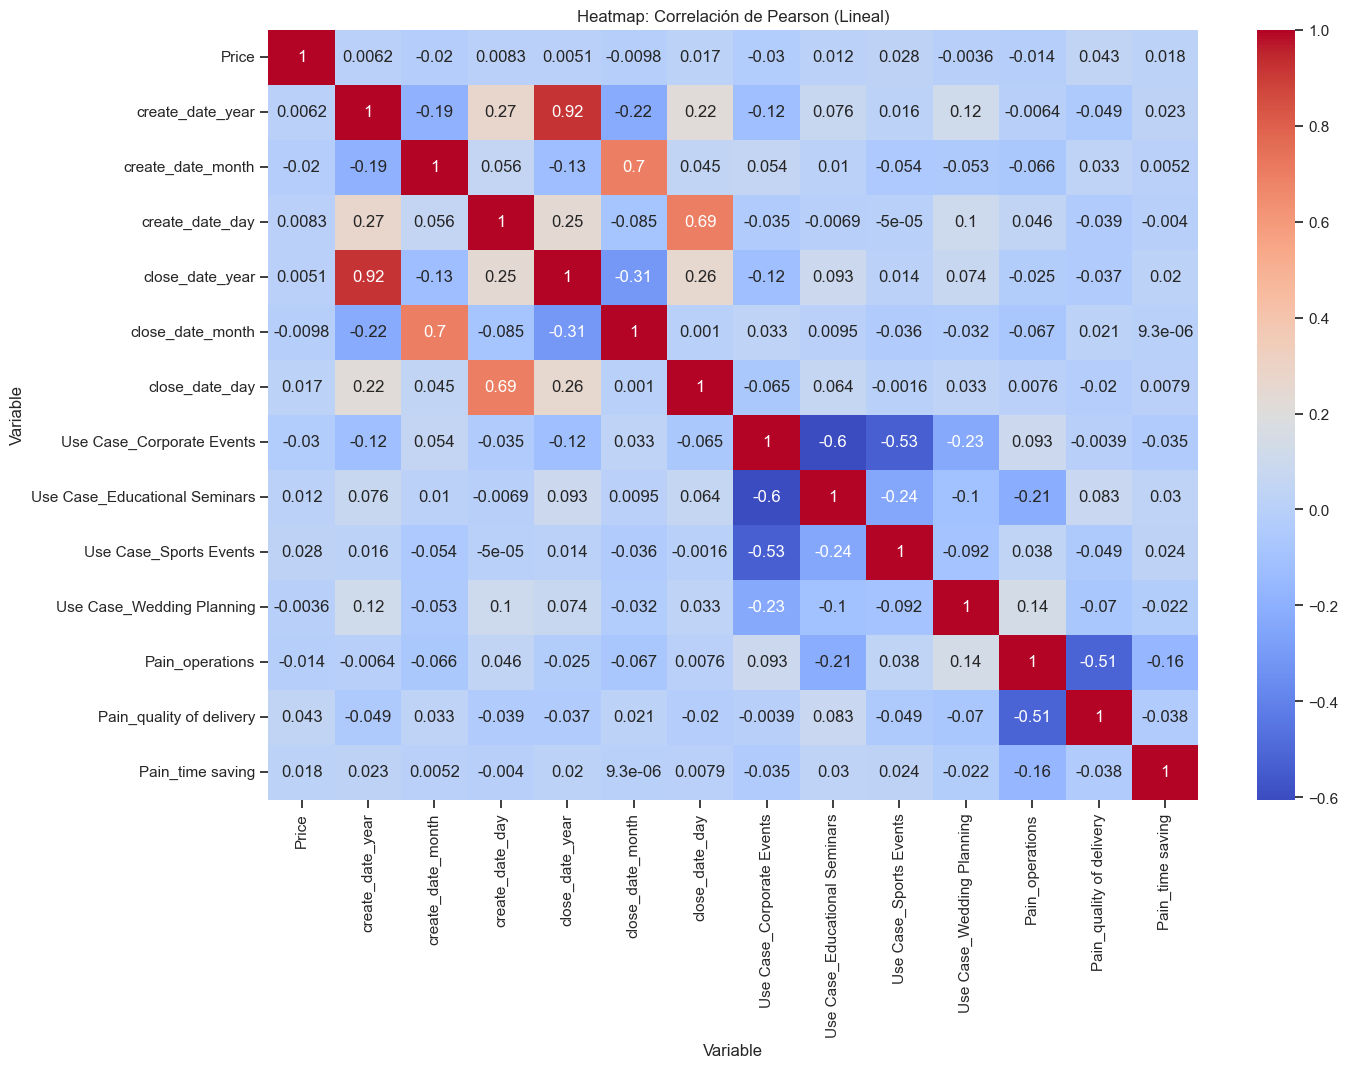

In [281]:
# Plot the covariance matrix heatmap
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(full_train1.corr(method='pearson'), annot=True, cmap='coolwarm', ax=ax)

# Set the axis labels
plt.xlabel('Variable')
plt.ylabel('Variable')

# Set the plot title
plt.title('Heatmap: Correlación de Pearson (Lineal)')

# Show the plot
plt.show()

#### Correlación de Ranking Kendall (Asociaciones Ordinales)

C:\Users\dfoso\AppData\Local\Temp\ipykernel_22644\1599402860.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  kendall_corr = full_train1.corr(method='kendall')


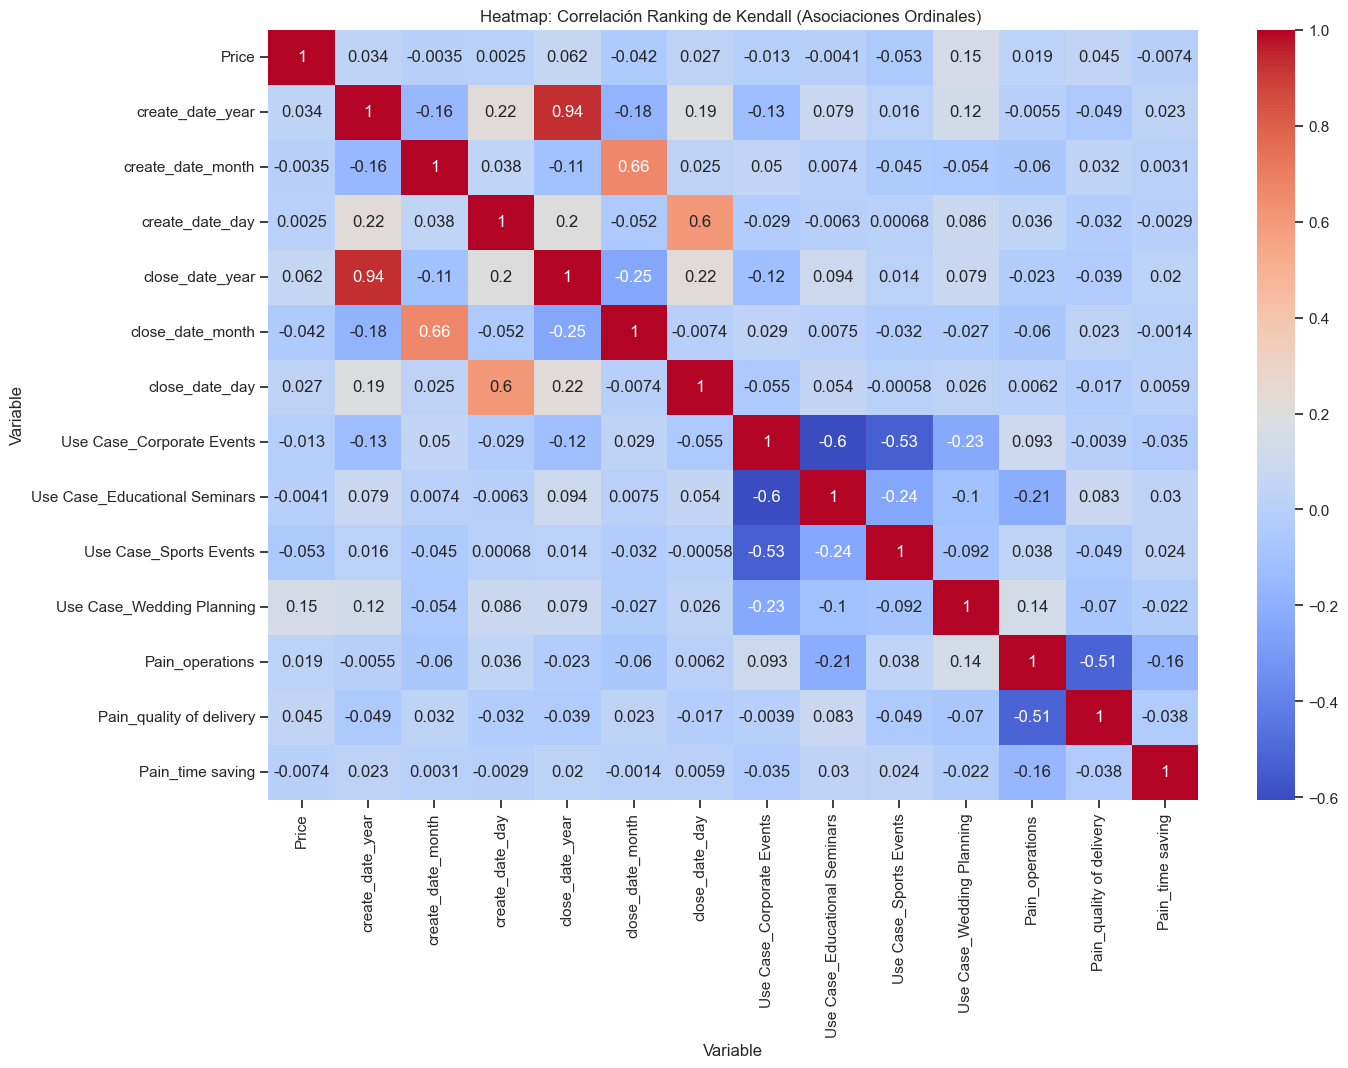

In [282]:
kendall_corr = full_train1.corr(method='kendall')

# Plot the Kendall Ranking matrix heatmap
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(kendall_corr, annot=True, cmap='coolwarm', ax=ax)

# Set the axis labels
plt.xlabel('Variable')
plt.ylabel('Variable')

# Set the plot title
plt.title('Heatmap: Correlación Ranking de Kendall (Asociaciones Ordinales) ')

# Show the plot
plt.show()

#### Matriz de Correlación

In [257]:
# crear matriz de correlación entre variables numericas en base de datos 
corr_matrix =full_train1.corr()
corr_matrix


C:\Users\dfoso\AppData\Local\Temp\ipykernel_22644\1617138921.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix =full_train1.corr()


Price  create_date_year  create_date_month  \
Price                          1.000000          0.006172          -0.020428   
create_date_year               0.006172          1.000000          -0.194662   
create_date_month             -0.020428         -0.194662           1.000000   
create_date_day                0.008314          0.271584           0.056090   
close_date_year                0.005143          0.924473          -0.127274   
close_date_month              -0.009772         -0.222461           0.697290   
close_date_day                 0.017044          0.220018           0.045123   
Use Case_Corporate Events     -0.029996         -0.121322           0.053791   
Use Case_Educational Seminars  0.012272          0.076015           0.010052   
Use Case_Sports Events         0.027669          0.016084          -0.053574   
Use Case_Wedding Planning     -0.003602          0.117398          -0.053043   
Pain_operations               -0.013946         -0.006389          -0.065555   
Pain_quality of delivery       0.042895         -0.049278           0.032852   
Pain_time saving               0.018258          0.022950           0.005242   

                               create_date_day  close_date_year  \
Price                                 0.008314         0.005143   
create_date_year                      0.271584         0.924473   
create_date_month                     0.056090        -0.127274   
create_date_day                       1.000000         0.245824   
close_date_year                       0.245824         1.000000   
close_date_month                     -0.085245        -0.310942   
close_date_day                        0.693576         0.257921   
Use Case_Corporate Events            -0.034779        -0.117101   
Use Case_Educational Seminars        -0.006914         0.093237   
Use Case_Sports Events               -0.000050         0.014054   
Use Case_Wedding Planning             0.104720         0.073578   
Pain_operations                       0.046072        -0.025265   
Pain_quality of delivery             -0.039008        -0.036630   
Pain_time saving                     -0.004028         0.019895   

                               close_date_month  close_date_day  \
Price                                 -0.009772        0.017044   
create_date_year                      -0.222461        0.220018   
create_date_month                      0.697290        0.045123   
create_date_day                       -0.085245        0.693576   
close_date_year                       -0.310942        0.257921   
close_date_month                       1.000000        0.001039   
close_date_day                         0.001039        1.000000   
Use Case_Corporate Events              0.032553       -0.065256   
Use Case_Educational Seminars          0.009497        0.063682   
Use Case_Sports Events                -0.035974       -0.001576   
Use Case_Wedding Planning             -0.031861        0.033222   
Pain_operations                       -0.066887        0.007621   
Pain_quality of delivery               0.021370       -0.020208   
Pain_time saving                       0.000009        0.007944   

                               Use Case_Corporate Events  \
Price                                          -0.029996   
create_date_year                               -0.121322   
create_date_month                               0.053791   
create_date_day                                -0.034779   
close_date_year                                -0.117101   
close_date_month                                0.032553   
close_date_day                                 -0.065256   
Use Case_Corporate Events                       1.000000   
Use Case_Educational Seminars                  -0.604664   
Use Case_Sports Events                         -0.531322   
Use Case_Wedding Planning                      -0.228766   
Pain_operations                                 0.093133   
Pain_quality of delivery                 

#### Pairplot

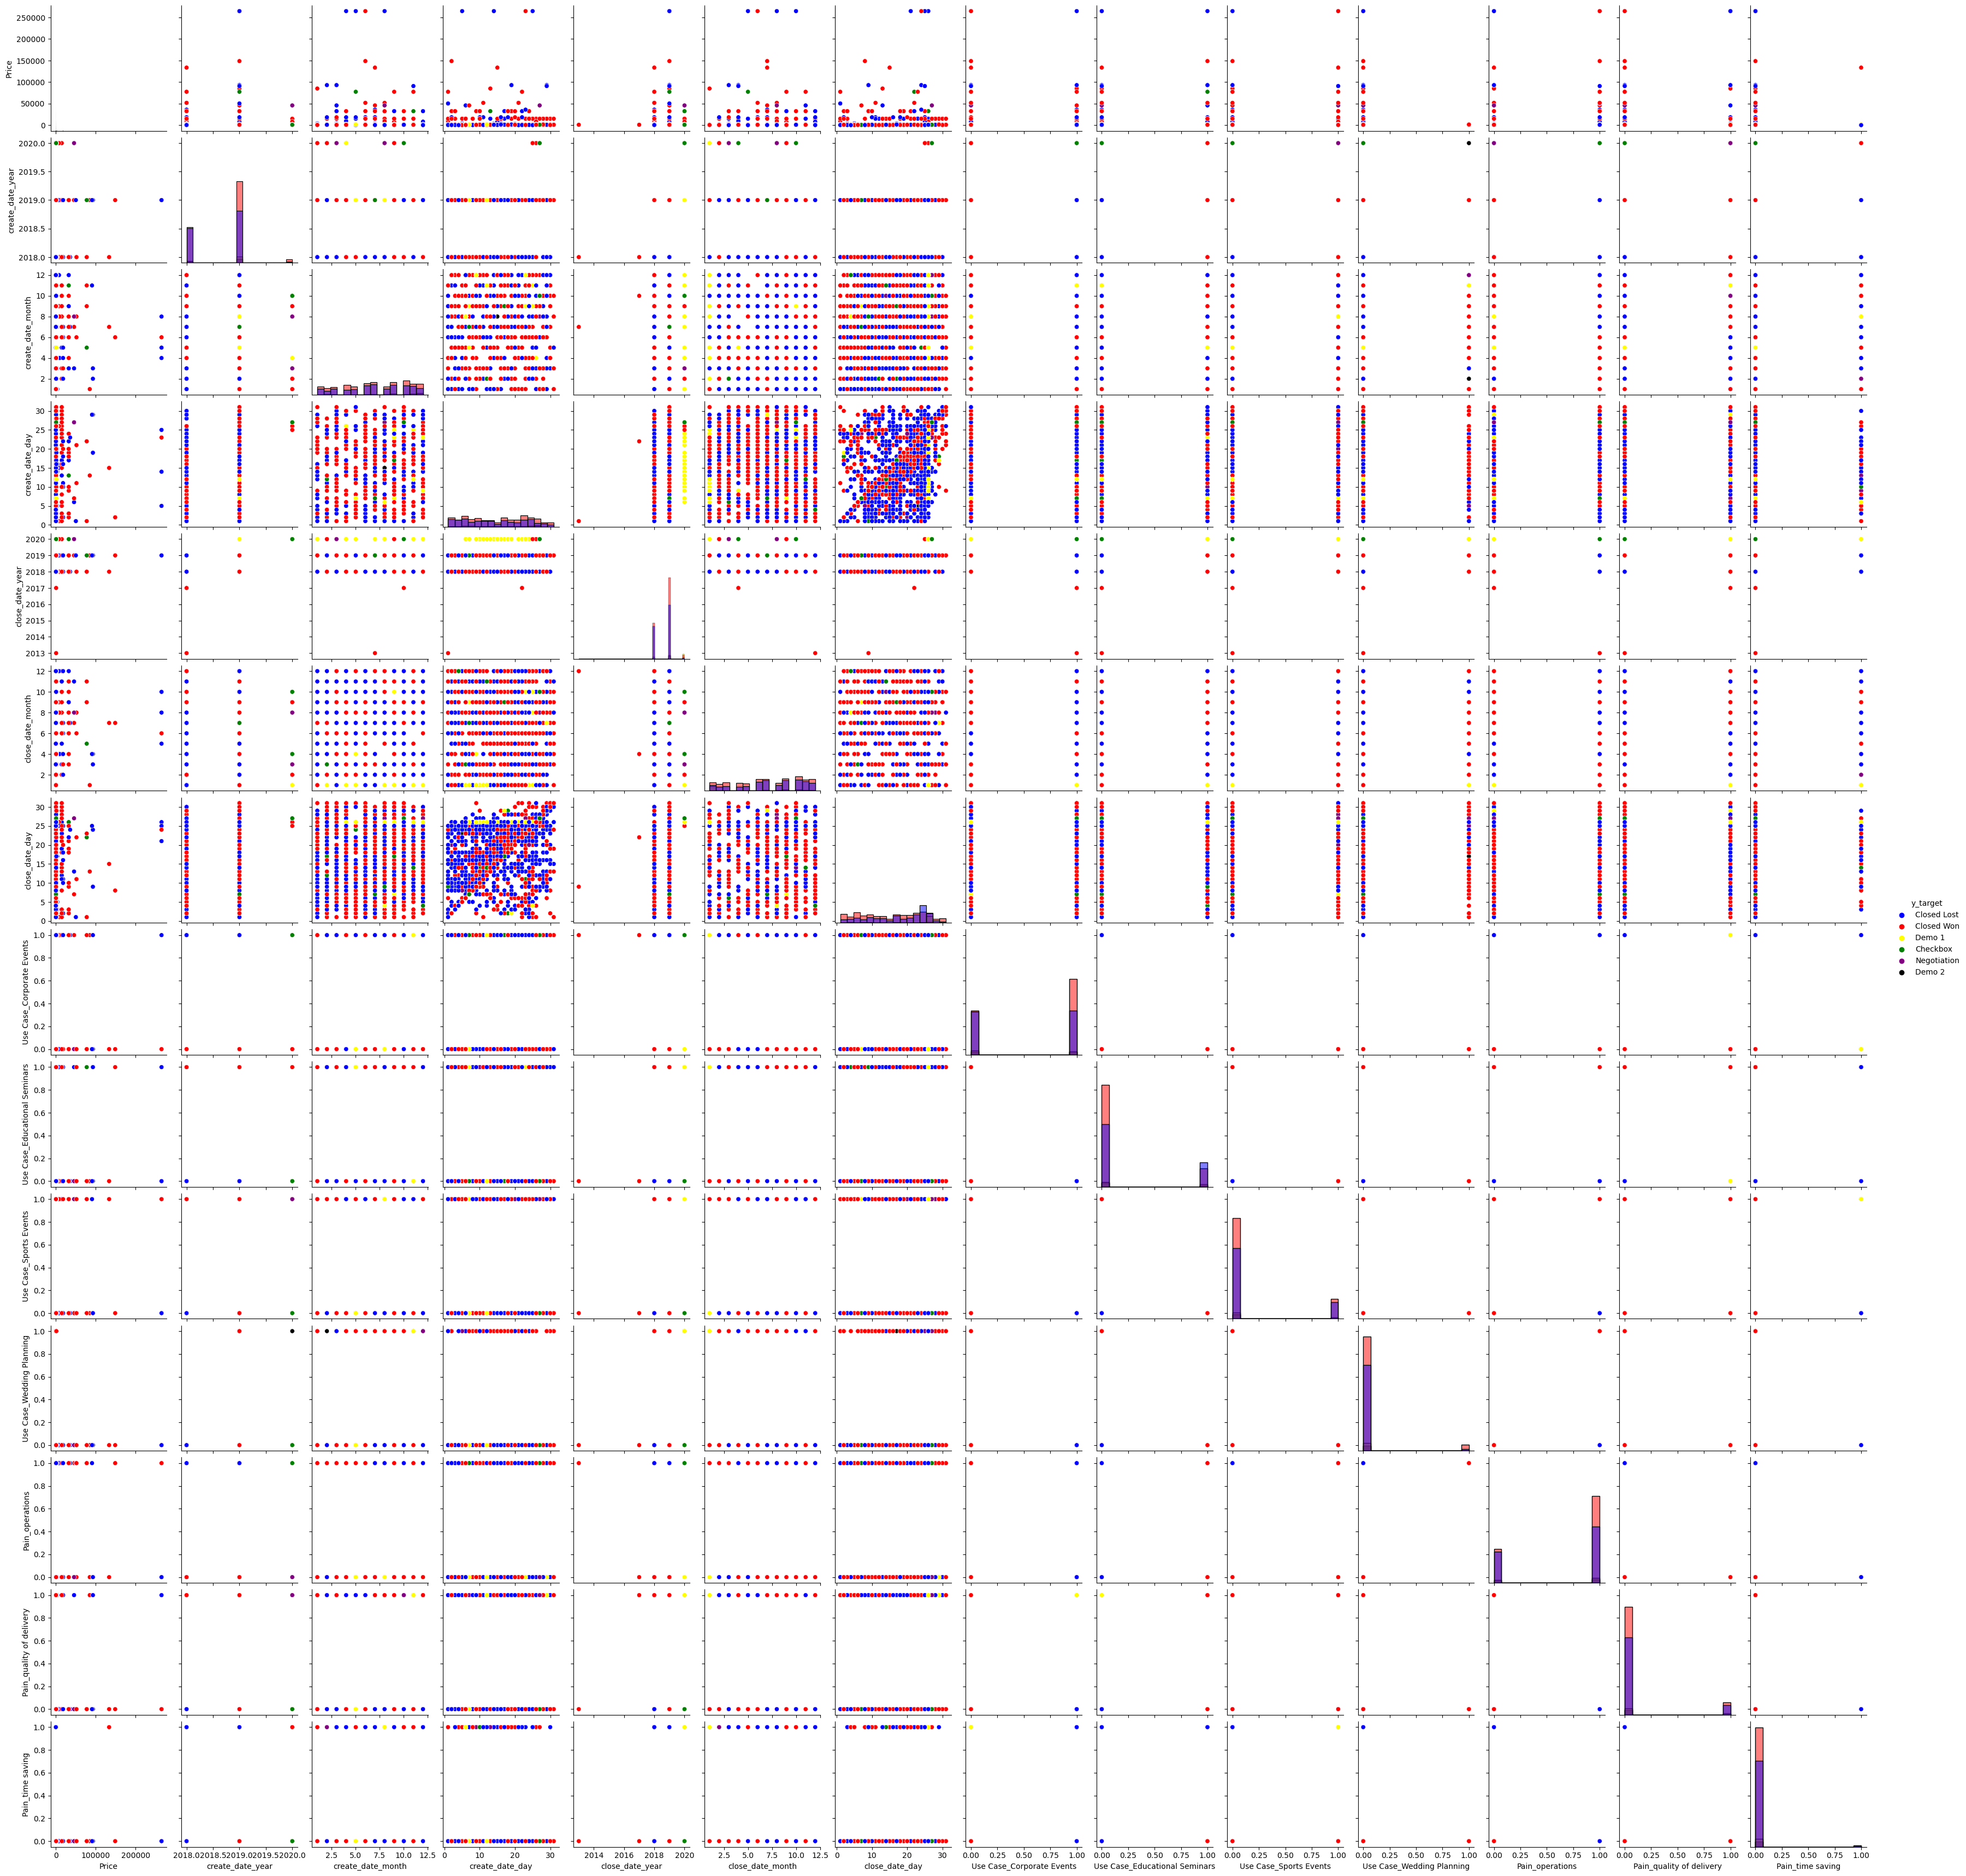

In [261]:
sns.pairplot(full_train1, diag_kind="hist", kind='scatter', hue='y_target', palette=['blue','red','yellow','green','purple','black'])

#### Matriz de Covarianza

C:\Users\dfoso\AppData\Local\Temp\ipykernel_22644\4062240114.py:2: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  covariance_matrix = full_train1.cov()


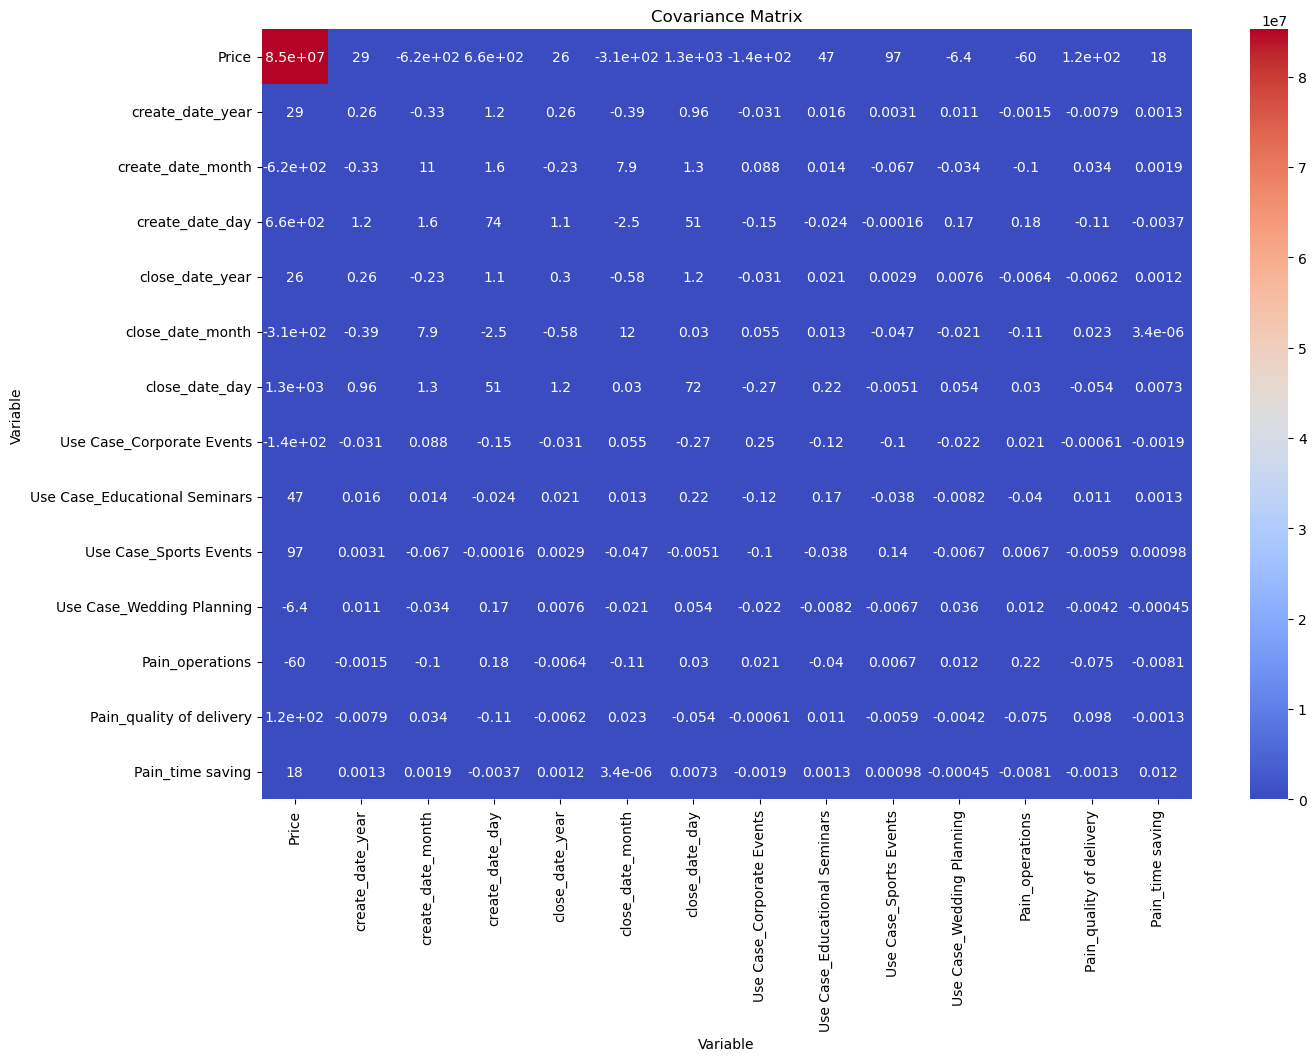

In [262]:
# Calculate the covariance matrix
covariance_matrix = full_train1.cov()

# Plot the covariance matrix heatmap
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(covariance_matrix, annot=True, cmap='coolwarm', ax=ax)

# Set the axis labels
plt.xlabel('Variable')
plt.ylabel('Variable')

# Set the plot title
plt.title('Covariance Matrix')

# Show the plot
plt.show()

#### Matriz de Dispersión

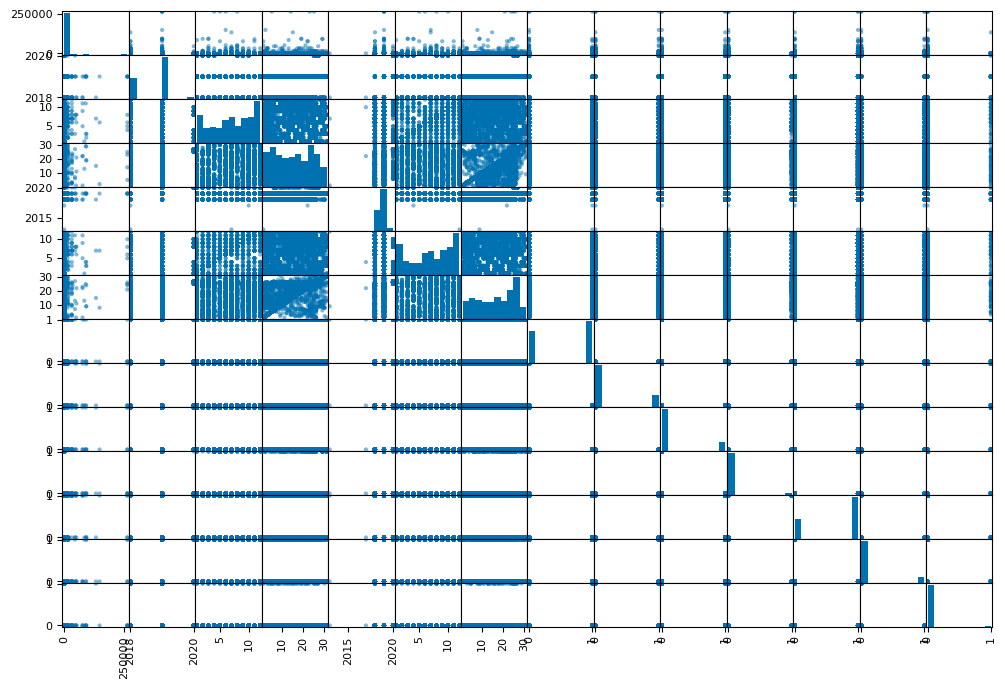

In [263]:
# Plot matriz de dispersion entre variables numéricas
scatter_matrix(full_train1, figsize=(12, 8))

# Hide x and y labels for each individual axis
for ax in plt.gcf().axes:
    ax.set_xlabel('')
    ax.set_ylabel('')
    
plt.show()

### Análisis de Distribución

In [283]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

#### Histogramas

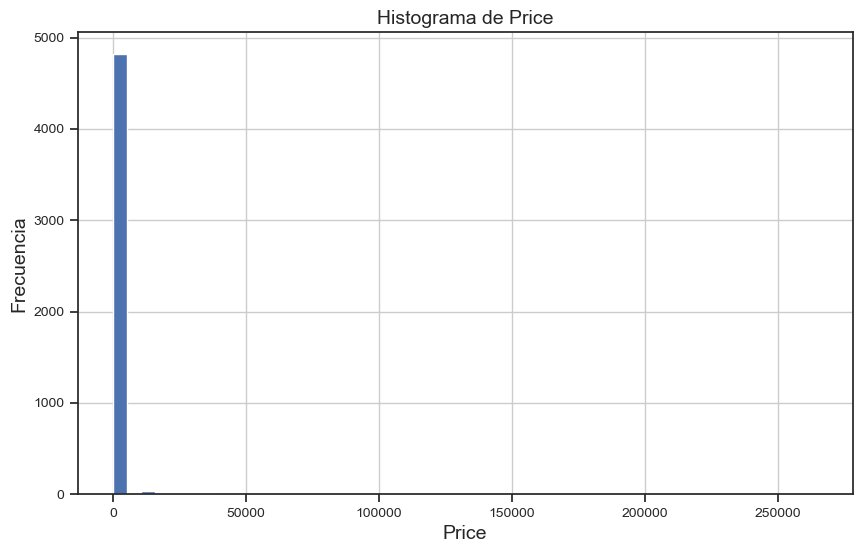

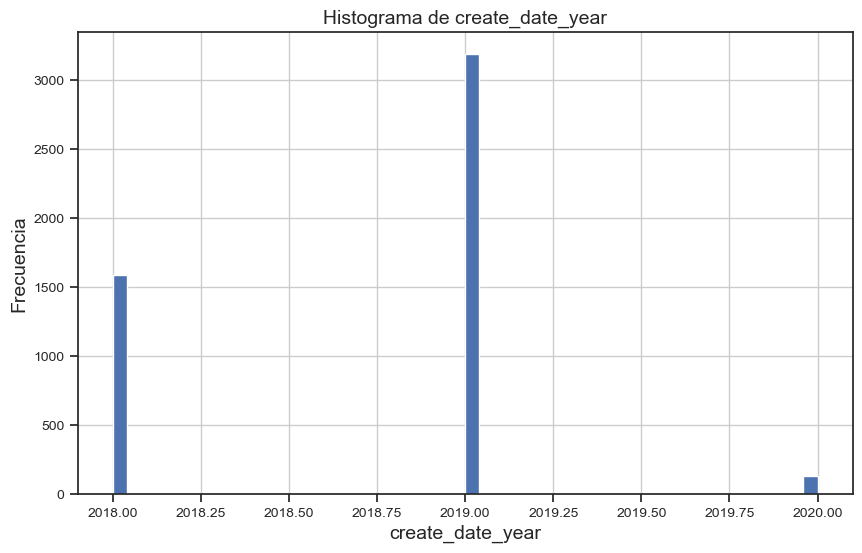

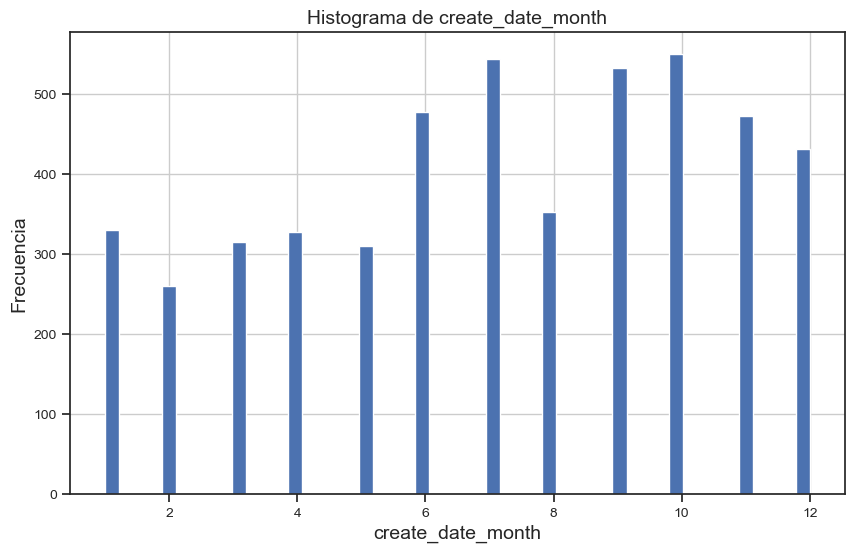

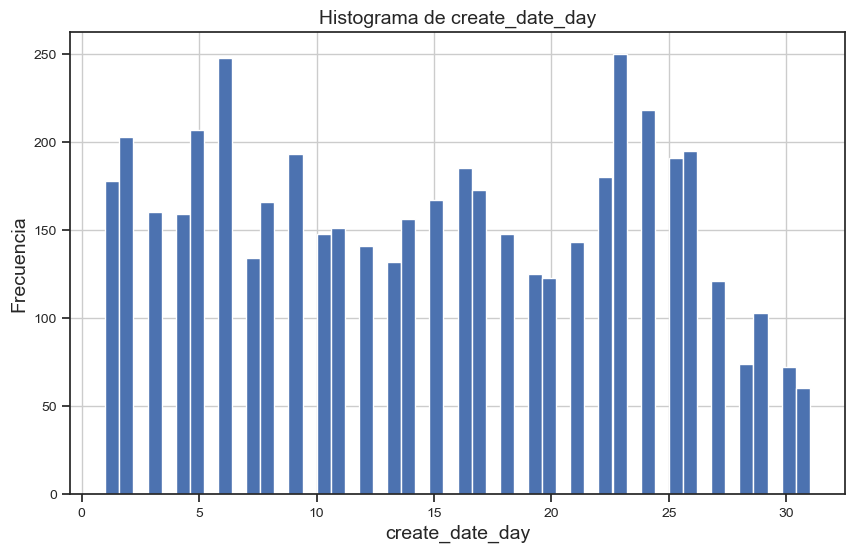

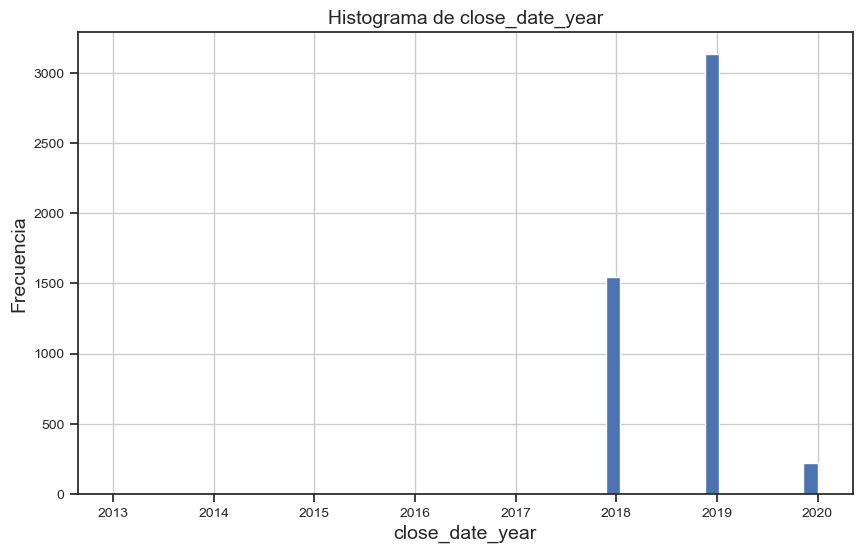

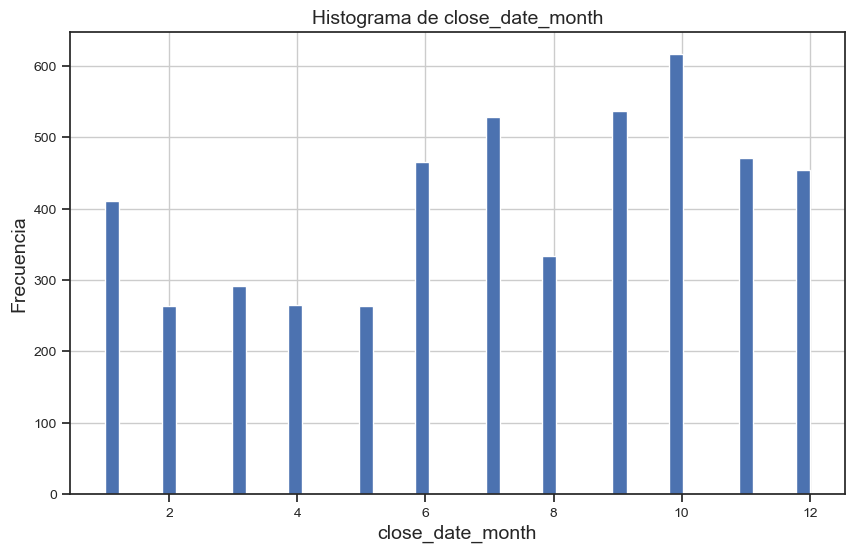

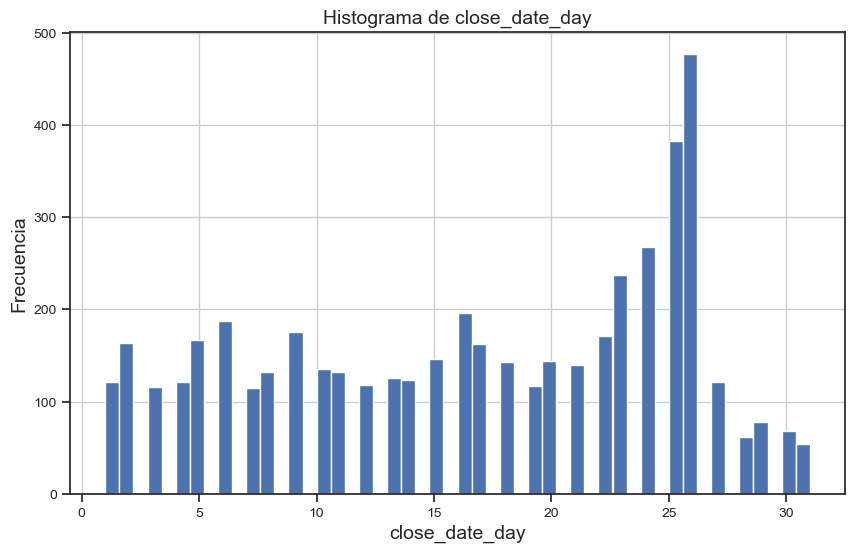

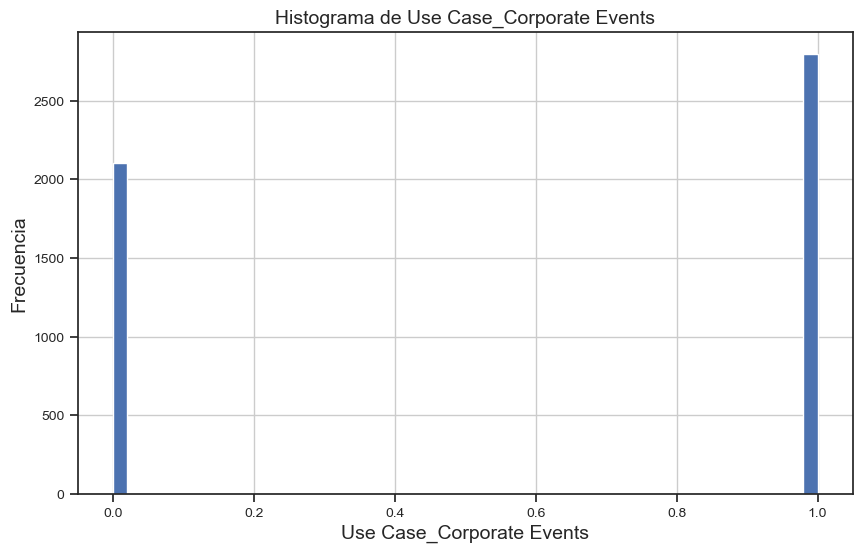

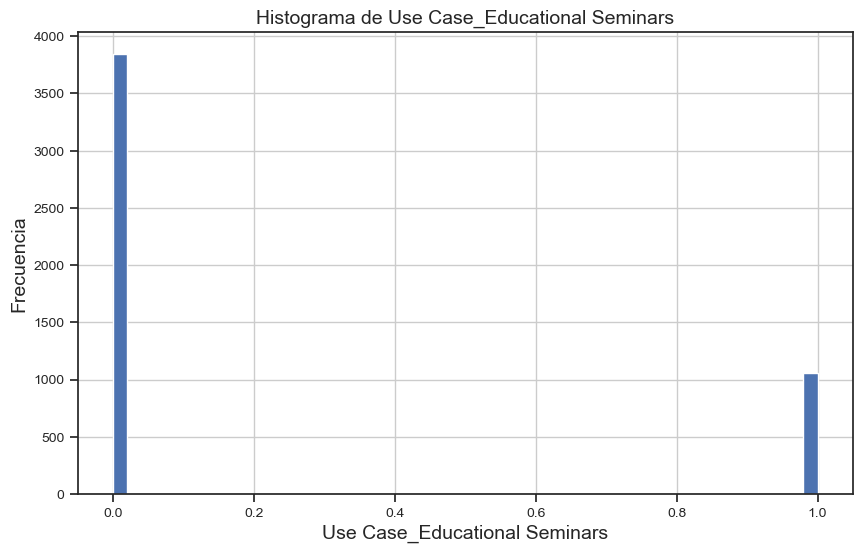

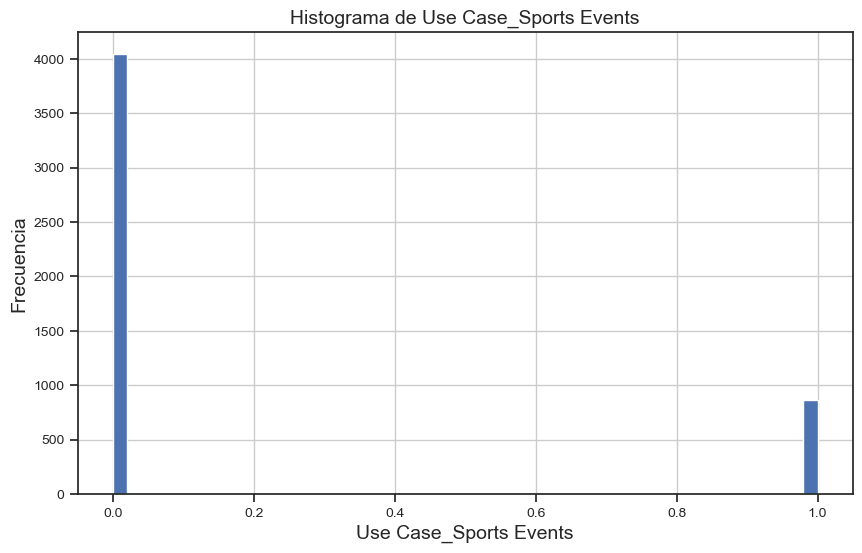

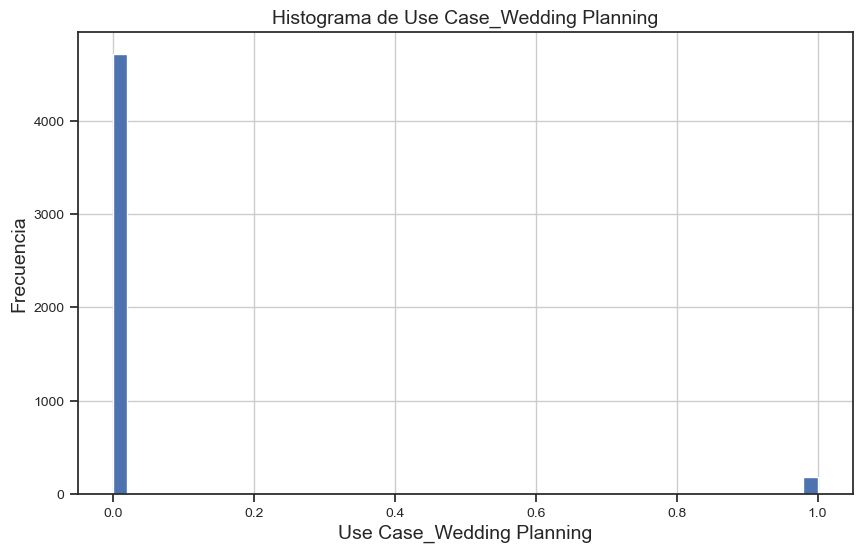

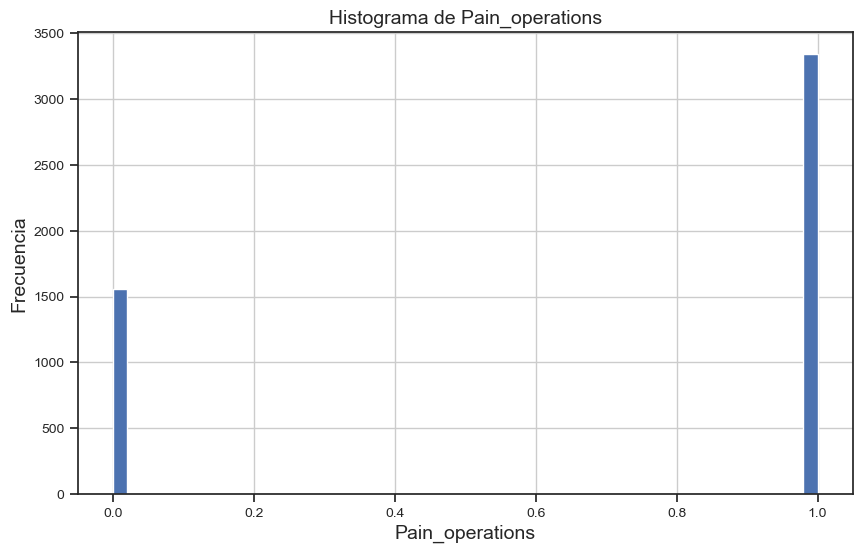

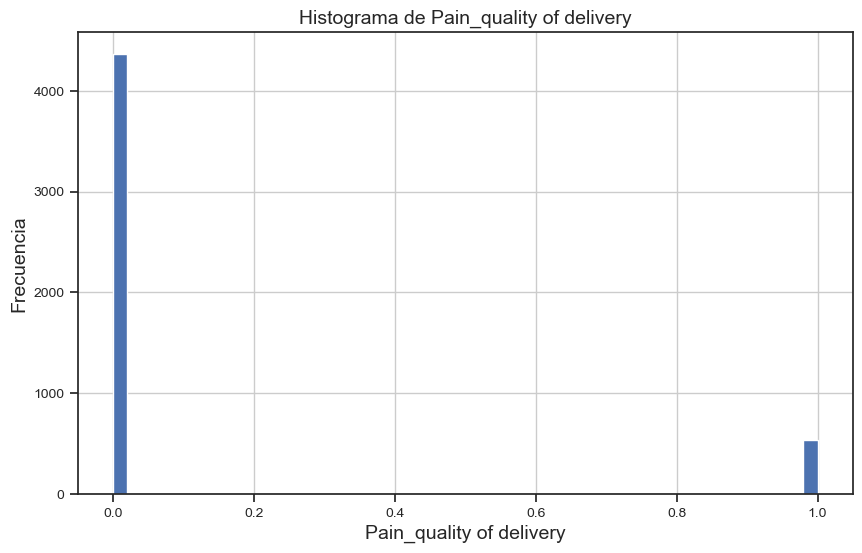

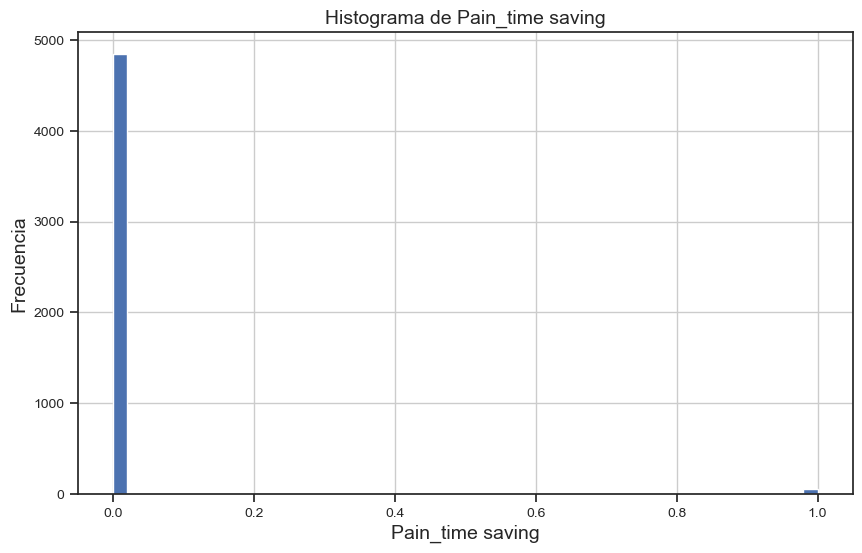

In [284]:
# Create a figure for each variable
for var in x_train1.columns:
    plt.figure(figsize=(10, 6))
    full_train1[var].hist(bins=50)
    plt.title(f'Histograma de {var}') 
    plt.xlabel(var)
    plt.ylabel('Frecuencia')
    plt.show()

#### Boxplot

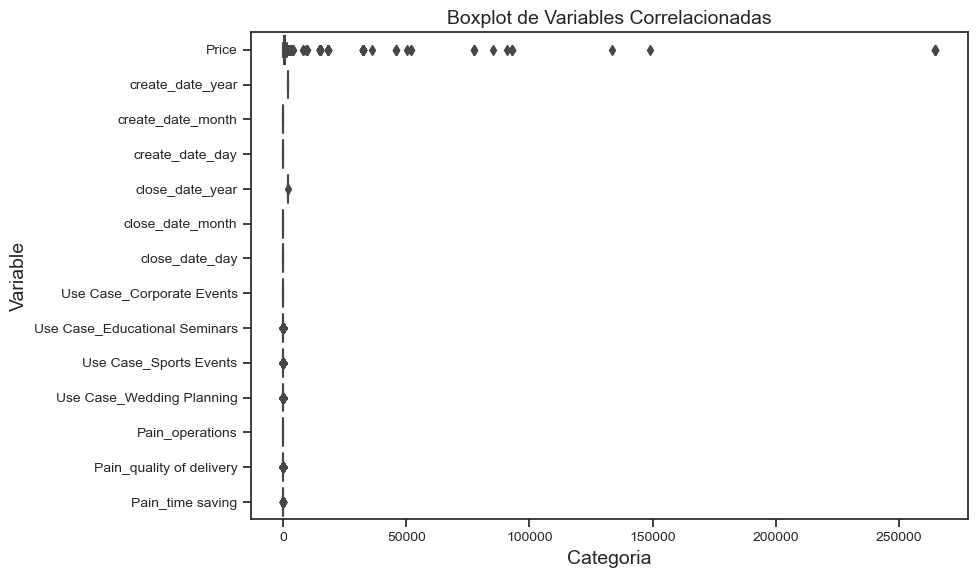

In [285]:
# plotting box plot
# using the orient parameter for orientation of each numeric variable
plt.figure(figsize=(10, 6))
sns.boxplot( data = full_train1, orient="h")  

plt.title('Boxplot de Variables Correlacionadas' )
plt.xlabel('Categoria')
plt.ylabel('Variable')
plt.xticks()  # Rotate x-axis labels if needed
plt.tight_layout()
plt.show()

### Aprendizaje No Supervisado

In [286]:
y_train1.value_counts()

Status     
Closed Won     2598
Closed Lost    1886
Demo 1          167
Negotiation     117
Checkbox        115
Demo 2           21
dtype: int64

#### Clusters

c:\Users\dfoso\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


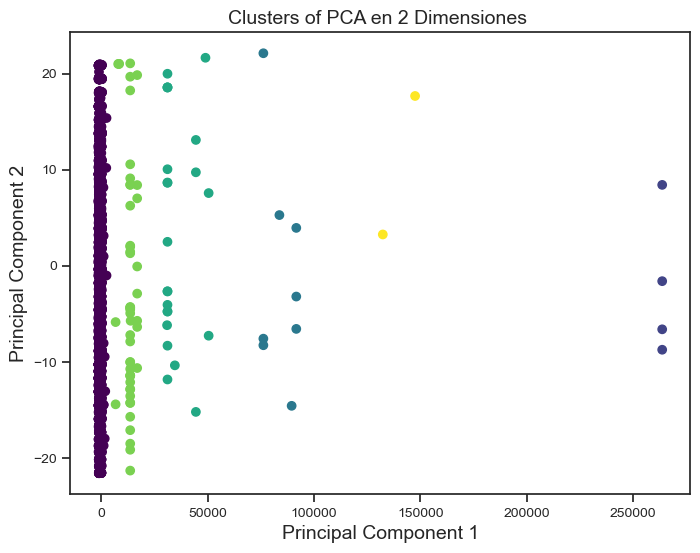

In [287]:
# extraer PCA a 2 componentres
# reducción de dimensionalidad a 2 componentes
pca = PCA(n_components=2, random_state=1)  # 
reduced_data = pca.fit_transform(x_train1)
reduced_data


# Clustering (K-Means)
kmeans = KMeans(n_clusters=6, random_state=1)
cluster_labels = kmeans.fit_predict(x_train1)

cluster_labels = kmeans.labels_

# Plot clusters
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Clusters of PCA en 2 Dimensiones ')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

#### PCA

In [288]:
# crear PCA (descomposición de valores singulares)
# 20 componentes principales
pca = PCA(n_components=5, svd_solver='full', random_state=1)

# entrenar PCA con datos de entrenamiento 
pca.fit_transform(x_train1)


explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

explained_variance_ratio, cumulative_explained_variance

(array([9.99997999e-01, 1.45691412e-06, 2.68628930e-07, 2.21039282e-07,
        3.83260781e-08]),
 array([0.999998  , 0.99999946, 0.99999972, 0.99999995, 0.99999998]))

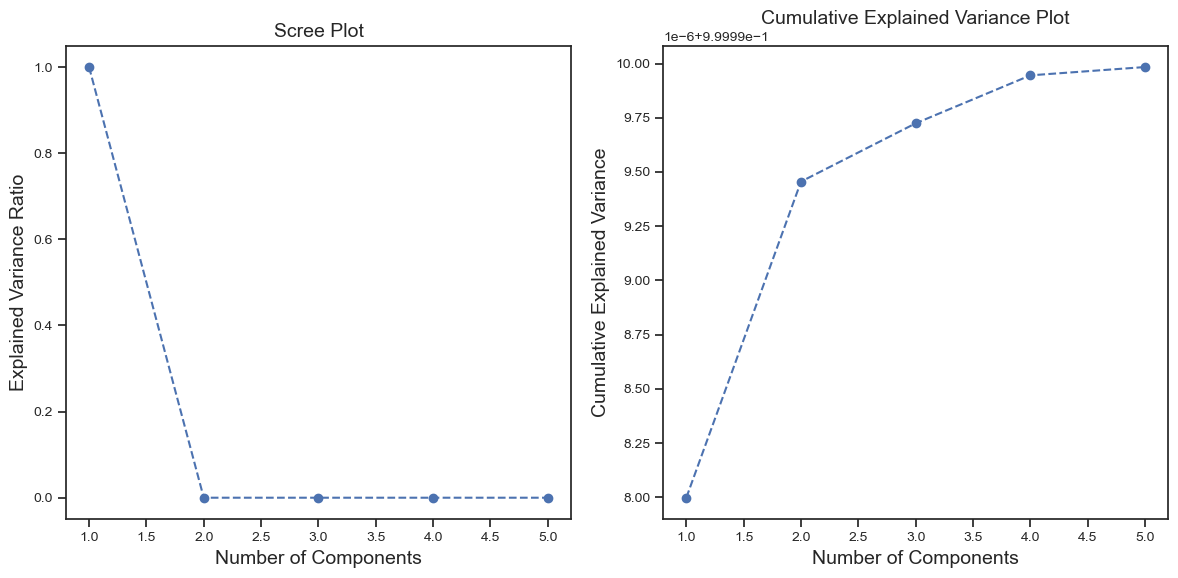

In [289]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot')

plt.tight_layout()
plt.show()

## Machine Learning

### Cargar bases de datos preprocesadas

In [10]:
# cargar datos de entrenamiento 
x_train1 = pd.read_csv('data/shimoku/x_train1preprocess.csv')
y_train1 = pd.read_csv('data/shimoku/y_train1preprocess.csv')

# cargar datos de prueba
x_test1 = pd.read_csv('data/shimoku/x_test1preprocess.csv')
y_test1 = pd.read_csv('data/shimoku/y_test1preprocess.csv')

In [20]:
# Create the label binarizer
lb = LabelEncoder()

# Fit the label binarizer on the target labels
lb.fit(y_train1)

# Transform the target labels to binary representation
y_train1_bin = lb.transform(y_train1)
y_test1_bin = lb.transform(y_test1)


y_train1_bin = pd.DataFrame(y_train1_bin, columns=["Status"])
y_test1_bin = pd.DataFrame(y_test1_bin, columns=["Status"])



c:\Users\dfoso\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\dfoso\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\dfoso\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


### Sintonización

In [483]:
# Búsqueda de Hiperparámetros
# modelos de Machine Learning (Clasificación Multi-clase)
xgb = XGBClassifier(n_jobs=-1, verbosity=3, random_state=1,  class_weight='balanced', validate_parameters=True, objective='multi:softmax', num_class=6, device= 'gpu')
lgb = LGBMClassifier(n_jobs=-1, random_state= 1, objective='multiclass', device = 'gpu', class_weight='balanced' , verbose = 0, num_class=6)  # class_weight='balanced'
rf = RandomForestClassifier(n_jobs=-1, verbose = 0, random_state=1, class_weight='balanced' )  # class_weight='balanced'  

params_rf = {'n_estimators':np.linspace(150,300,num=3,dtype=int), 'max_depth': np.linspace(3,15,num=3,dtype=int), 'min_samples_split': np.linspace(500,800,num=3,dtype=int) , 'min_samples_leaf': np.linspace(50,100,num=3,dtype=int) }  # , 'scale_pos_weight':[10,99,1000], 'min_samples_leaf':np.linspace(2,30,num=3,dtype=int), 'max_features':[3,6,9], 'oob_score':[True,False], 'max_features':['sqrt', 'log2']
grid_rf = GridSearchCV(rf, param_grid=params_rf, scoring= 'f1_macro', n_jobs=-1, cv=5, verbose = 3)

#XGBoost
params_xgb = {'n_estimators':np.linspace(150,300,num=3,dtype=int), 'max_depth': np.linspace(3,15,num=3,dtype=int), 'learning_rate':np.linspace(0.01,1,num=3,dtype=float) , 'min_child_weight':np.linspace(0.01,1,num=3,dtype=float) } # 'scale_pos_weight':[10,99,1000], 'booster':['gbtree','dart'], 'eta':np.linspace(0.01,0.3,num=3,dtype=float)
grid_xgb =  GridSearchCV(xgb, param_grid=params_xgb, scoring= 'f1_macro', n_jobs=-1, cv=5, verbose = 3)

#LightGBM
params_lgbm = {'n_estimators':np.linspace(150,300,num=3,dtype=int), 'max_depth': np.linspace(3,15,num=3,dtype=int), 'learning_rate':np.linspace(0.01,1,num=3,dtype=float), 'min_child_samples': np.linspace(50,100,num=2,dtype=int),  'max_features': ['sqrt', 256] }  # 'scale_pos_weight':[10,99,1000] 
grid_lgbm =  GridSearchCV(lgb, param_grid=params_lgbm, scoring= 'f1_macro', n_jobs=-1, cv=5, verbose = 3)


### Entrenamiento

#### Random Forest

In [484]:
grid_rf.fit(x_train1, y_train1 )
joblib.dump(grid_rf, 'data/modelos/shimoku/RandomForestClassifier.pkl')   

Fitting 5 folds for each of 81 candidates, totalling 405 fits


c:\Users\dfoso\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


['data/modelos/shimoku/RandomForestClassifier.pkl']

#### XGBoost

In [485]:
grid_xgb.fit(x_train1, y_train1_bin)
joblib.dump(grid_xgb, 'data/modelos/shimoku/XGBoostClassifier.pkl')   

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[20:03:30] ======== Monitor (0): HostSketchContainer ========
[20:03:30] AllReduce: 0.000317s, 1 calls @ 317us

[20:03:30] MakeCuts: 0.000353s, 1 calls @ 353us

[20:03:30] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0


c:\Users\dfoso\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [20:03:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\dfoso\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [20:03:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[20:03:32] ======== Monitor (0): Learner ========
[20:03:32] Configure: 0.00071s, 1 calls @ 710us

[20:03:32] EvalOneIter: 0.003594s, 300 calls @ 3594us

[20:03:32] GetGradient: 0.144519s, 300 calls @ 144519us

[20:03:32] PredictRaw: 0.000429s, 300 calls @ 429us

[20:03:32] UpdateOneIter: 1.85731s, 300 calls @ 1857309us

[20:03:32] ======== Monitor (0): GBTree ========
[20:03:32] BoostNewTrees: 1.70929s, 300 calls @ 1709286us

[20:03:32] CommitModel: 0.000341s, 300 calls @ 341us

[20:03:32] ======== Monitor (0): HistUpdater ========
[20:03:32] BuildHistogram: 0.520497s, 14838 calls @ 520497us

[20:03:32] EvaluateSplits: 0.421185s, 16638 calls @ 421185us

[20:03:32] InitData: 0.043751s, 1800 calls @ 43751us

[20:03:32] InitRoot: 0.15275s, 1800 calls @ 152750us

[20:03:32] LeafPartition: 0.00023s, 1800 calls @ 230us

[20:03:32] UpdatePosition: 0.369411s, 15388 calls @ 369411us

[20:03:32] UpdatePredictionCache: 0.037502s, 1800 calls @ 37502us

[20:03:32] UpdateTree: 1.62388s, 1800 calls 

['data/modelos/shimoku/XGBoostClassifier.pkl']

#### LightGBM

In [486]:
grid_lgbm.fit(x_train1, y_train1 )
joblib.dump(grid_lgbm, 'data/modelos/shimoku/LightGBMClassifier.pkl')   

Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\dfoso\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\dfoso\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

['data/modelos/shimoku/LightGBMClassifier.pkl']

### Selección de Modelo

In [4]:
# cargar modelos sintonizados
grid_rf = joblib.load('data/modelos/shimoku/RandomForestClassifier.pkl')
grid_lgbm = joblib.load('data/modelos/shimoku/LightGBMClassifier.pkl')
grid_xgb = joblib.load('data/modelos/shimoku/XGBoostClassifier.pkl')

In [5]:
# extraer mejores modelos
rf_op = grid_rf.best_estimator_
lgbm_op = grid_lgbm.best_estimator_
xgb_op = grid_xgb.best_estimator_

In [40]:
# metricas de evaluacion
classifier_names = []

classifier_acc = []# (TP+TN)/TOT

classifier_recall_micro = []# rec = 1-FNR
classifier_recall_macro = []
classifier_recall_weighted = []

classifier_spec = []# spec = 1-FPR

classifier_precision_micro= []# prec = 1-FDR
classifier_precision_macro= []
classifier_precision_weighted = []

classifier_f1_micro = []# media armonica entre precision y recall
classifier_f1_macro = []
classifier_f1_weighted = []


# ROC multiclase
# ROC OneVsRest # TPR vs. FPR 
classifier_roc_micro_ovr = []
classifier_roc_macro_ovr = []
classifier_roc_weighted_ovr = []

# matriz de confusión
classifier_confusion = []

# otras metricas
classifier_balanced_acc = []
classifier_cohen_kappa = []
classifier_hinge_loss = []
classifier_matthews_corrcoef = []
classifier_top_k_accuracy = []



In [41]:
# metricas de evaluacion
classifier_names_xgb = []

classifier_acc_xgb = []# (TP+TN)/TOT

classifier_recall_micro_xgb = []# rec = 1-FNR
classifier_recall_macro_xgb = []
classifier_recall_weighted_xgb = []

classifier_spec_xgb = []# spec = 1-FPR

classifier_precision_micro_xgb= []# prec = 1-FDR
classifier_precision_macro_xgb= []
classifier_precision_weighted_xgb = []

classifier_f1_micro_xgb = []# media armonica entre precision y recall
classifier_f1_macro_xgb = []
classifier_f1_weighted_xgb = []


# ROC multiclase
# ROC OneVsRest # TPR vs. FPR 
classifier_roc_micro_ovr_xgb = []
classifier_roc_macro_ovr_xgb = []
classifier_roc_weighted_ovr_xgb = []

# matriz de confusión
classifier_confusion_xgb = []

# otras metricas
classifier_balanced_acc_xgb = []
classifier_cohen_kappa_xgb = []
classifier_hinge_loss_xgb = []
classifier_matthews_corrcoef_xgb = []
classifier_top_k_accuracy_xgb = []



In [44]:
classifiers = [('Random Forest', rf_op),
               ('LightGBM', lgbm_op),
               ] 
            
# agregar nombres de clasificadores a lista
for classifier in classifiers:
    classifier_names.append(classifier[0])

In [42]:
classifiers_xgb = [('XGBoost', xgb_op),
               ] 
# agregar nombres de clasificadores a lista
for classifier in classifiers_xgb:
    classifier_names_xgb.append(classifier[0])

#### Curvas ROC-AUC

##### ROC por clase 

c:\Users\dfoso\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo de Clasificación: Random Forest



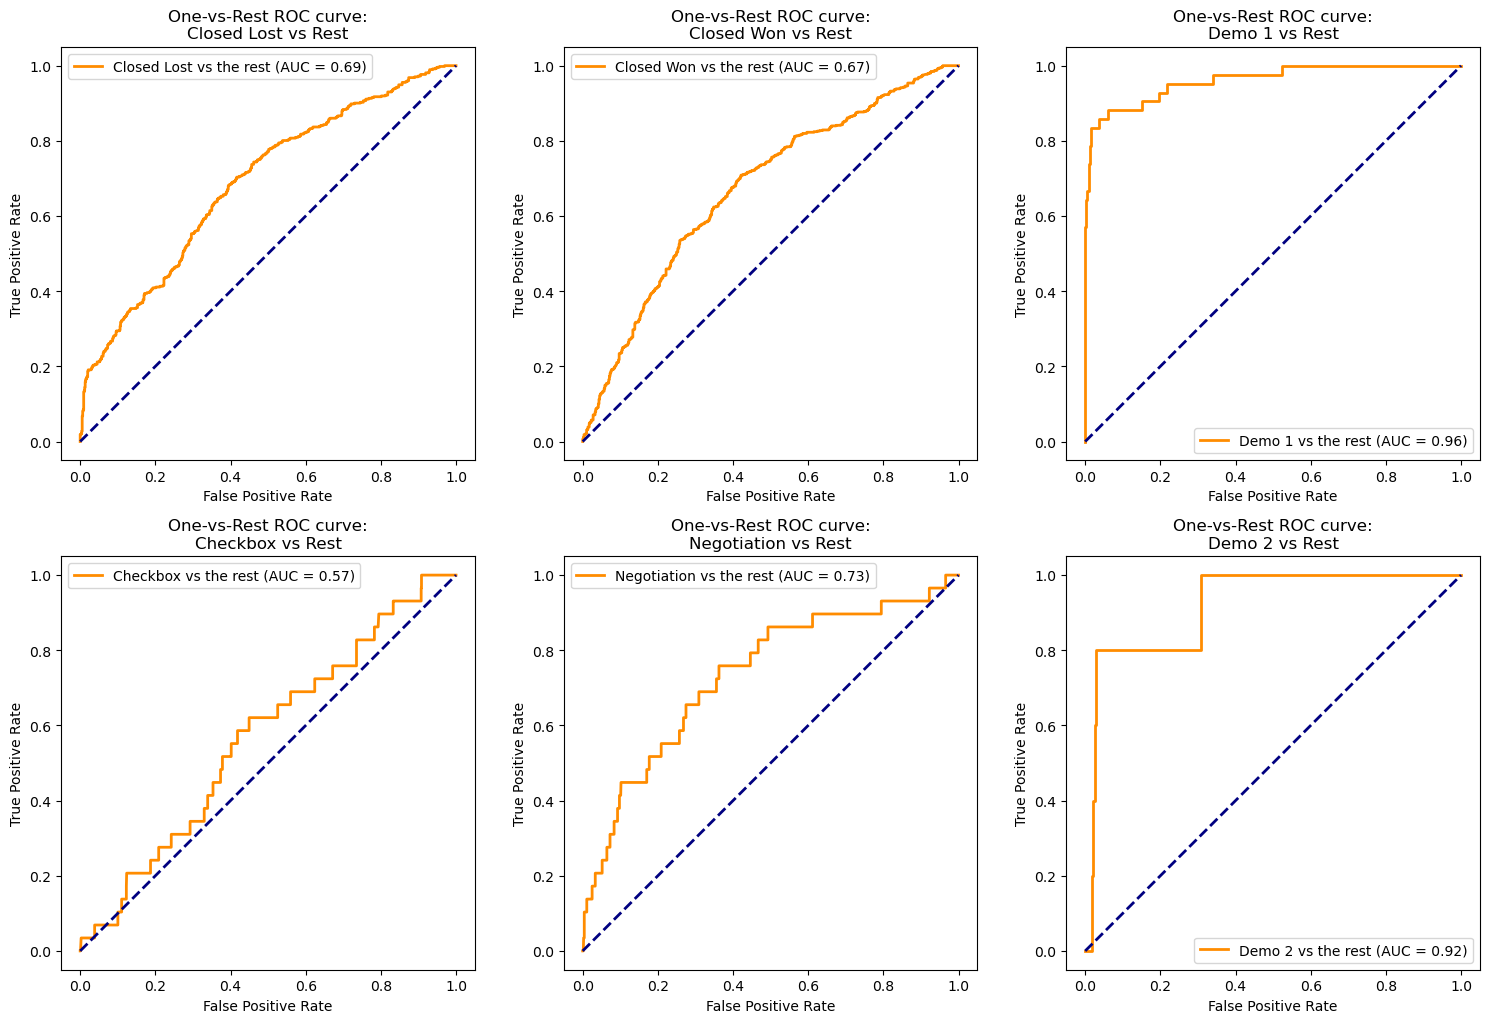

c:\Users\dfoso\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\dfoso\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

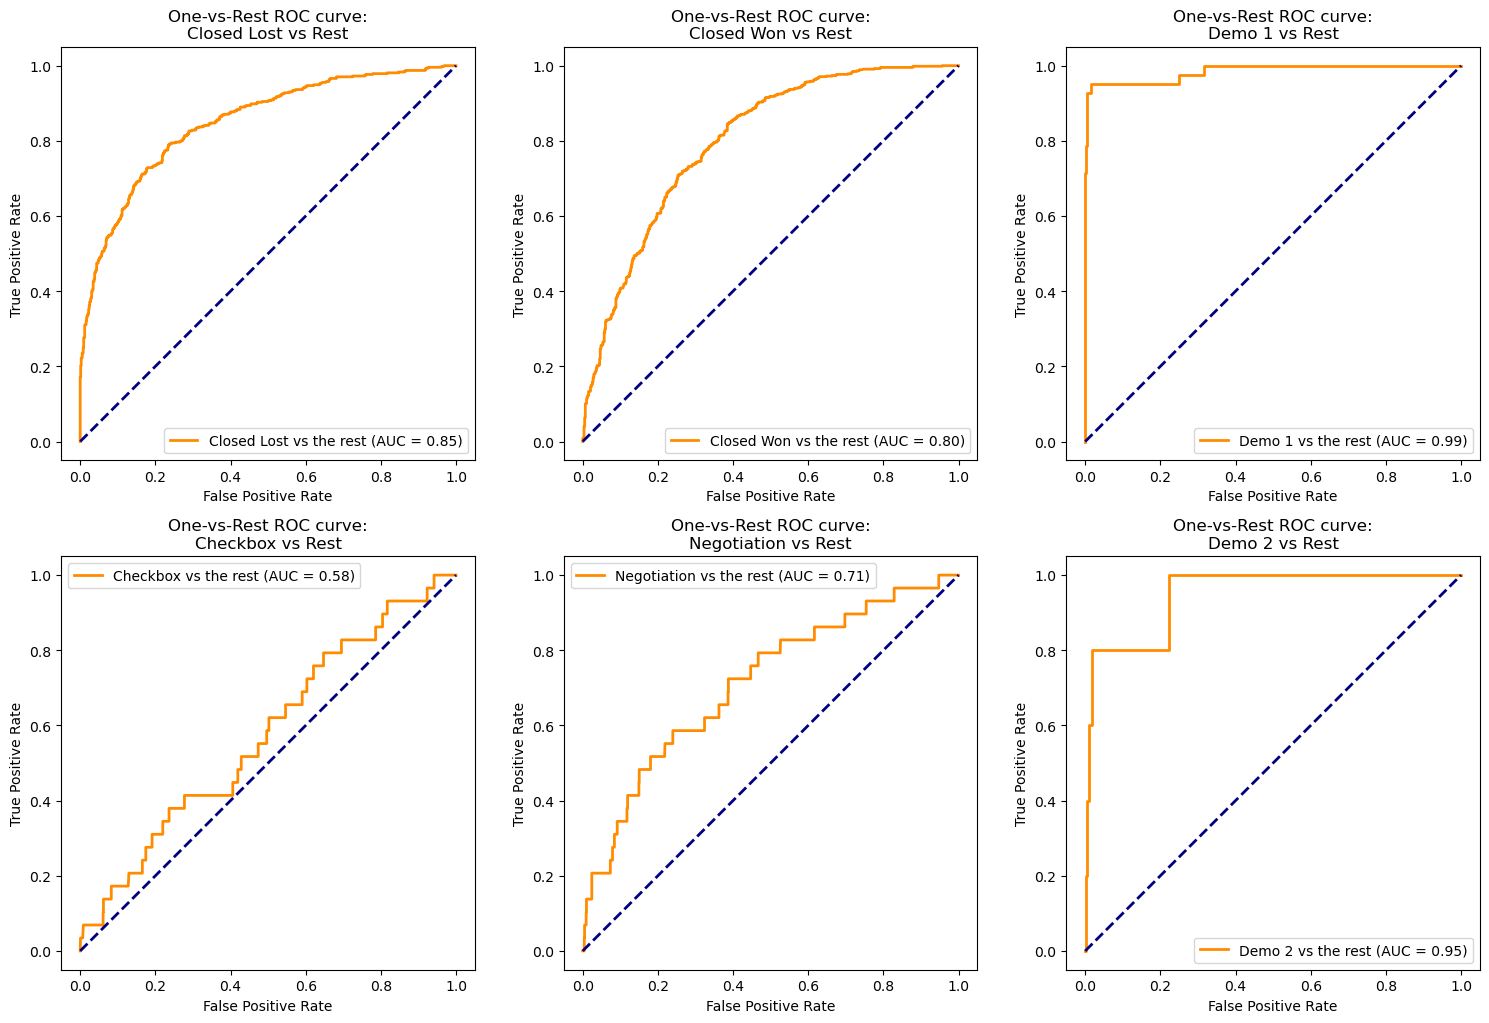

In [16]:
for classifier_name, classifier in classifiers:
    # ajustar modelo sintonizado con datos de entrenamiento
    classifier.fit(x_train1, y_train1)    

    # crear y_predict vector de predicciones
    y_predict = classifier.predict(x_test1)
    
    # calcular probabilidad de pertenencia a clase
    y_score = classifier.predict_proba(x_test1)
    
    # ROC OnevsRest
    label_binarizer = LabelBinarizer().fit(y_train1)
    y_onehot_test = label_binarizer.transform(y_test1)
    
    # clases en y-target
    clases = y_train1['Status'].unique().tolist()
    
    print("Modelo de Clasificación: "+ str(classifier_name) )
    print("")
    
    # Create subplots
    fig, axes = plt.subplots(nrows=len(clases) // 3 + 1, ncols=3, figsize=(15, 5 * (len(clases) // 3 + 1)))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    
    
    for i, class_of_interest in enumerate(clases):
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

        # ROC OnevsRest
        fpr, tpr, _ = roc_curve(y_onehot_test[:, class_id], y_score[:, class_id])
        roc_auc = auc(fpr, tpr)

        ax = axes[i // 3, i % 3]
        ax.plot(fpr, tpr, color="darkorange", lw=2, label=f"{class_of_interest} vs the rest (AUC = {roc_auc:.2f})")
        ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(f"One-vs-Rest ROC curve:\n{class_of_interest} vs Rest")
        ax.legend(loc="best")
        ax.axis("square")

    # Remove any empty subplots
    for i in range(len(clases), (len(clases) // 3 + 1) * 3):
        fig.delaxes(axes.flatten()[i])

    # Adjust layout
    plt.tight_layout()
    plt.show()

[16:03:28] ======== Monitor (0): HostSketchContainer ========
[16:03:28] AllReduce: 0.000401s, 1 calls @ 401us

[16:03:28] MakeCuts: 0.000433s, 1 calls @ 433us

[16:03:28] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0


c:\Users\dfoso\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:03:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\dfoso\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:03:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[16:03:30] ======== Monitor (0): Learner ========
[16:03:30] Configure: 0.003633s, 1 calls @ 3633us

[16:03:30] EvalOneIter: 0.003472s, 300 calls @ 3472us

[16:03:30] GetGradient: 0.183104s, 300 calls @ 183104us

[16:03:30] PredictRaw: 0.000722s, 300 calls @ 722us

[16:03:30] UpdateOneIter: 1.93722s, 300 calls @ 1937221us

[16:03:30] ======== Monitor (0): GBTree ========
[16:03:30] BoostNewTrees: 1.74735s, 300 calls @ 1747350us

[16:03:30] CommitModel: 0.000361s, 300 calls @ 361us

[16:03:30] ======== Monitor (0): HistUpdater ========
[16:03:30] BuildHistogram: 0.519924s, 14838 calls @ 519924us

[16:03:30] EvaluateSplits: 0.394255s, 16638 calls @ 394255us

[16:03:30] InitData: 0.038635s, 1800 calls @ 38635us

[16:03:30] InitRoot: 0.16907s, 1800 calls @ 169070us

[16:03:30] LeafPartition: 0.000204s, 1800 calls @ 204us

[16:03:30] UpdatePosition: 0.361968s, 15388 calls @ 361968us

[16:03:30] UpdatePredictionCache: 0.080654s, 1800 calls @ 80654us

[16:03:30] UpdateTree: 1.60752s, 1800 cal

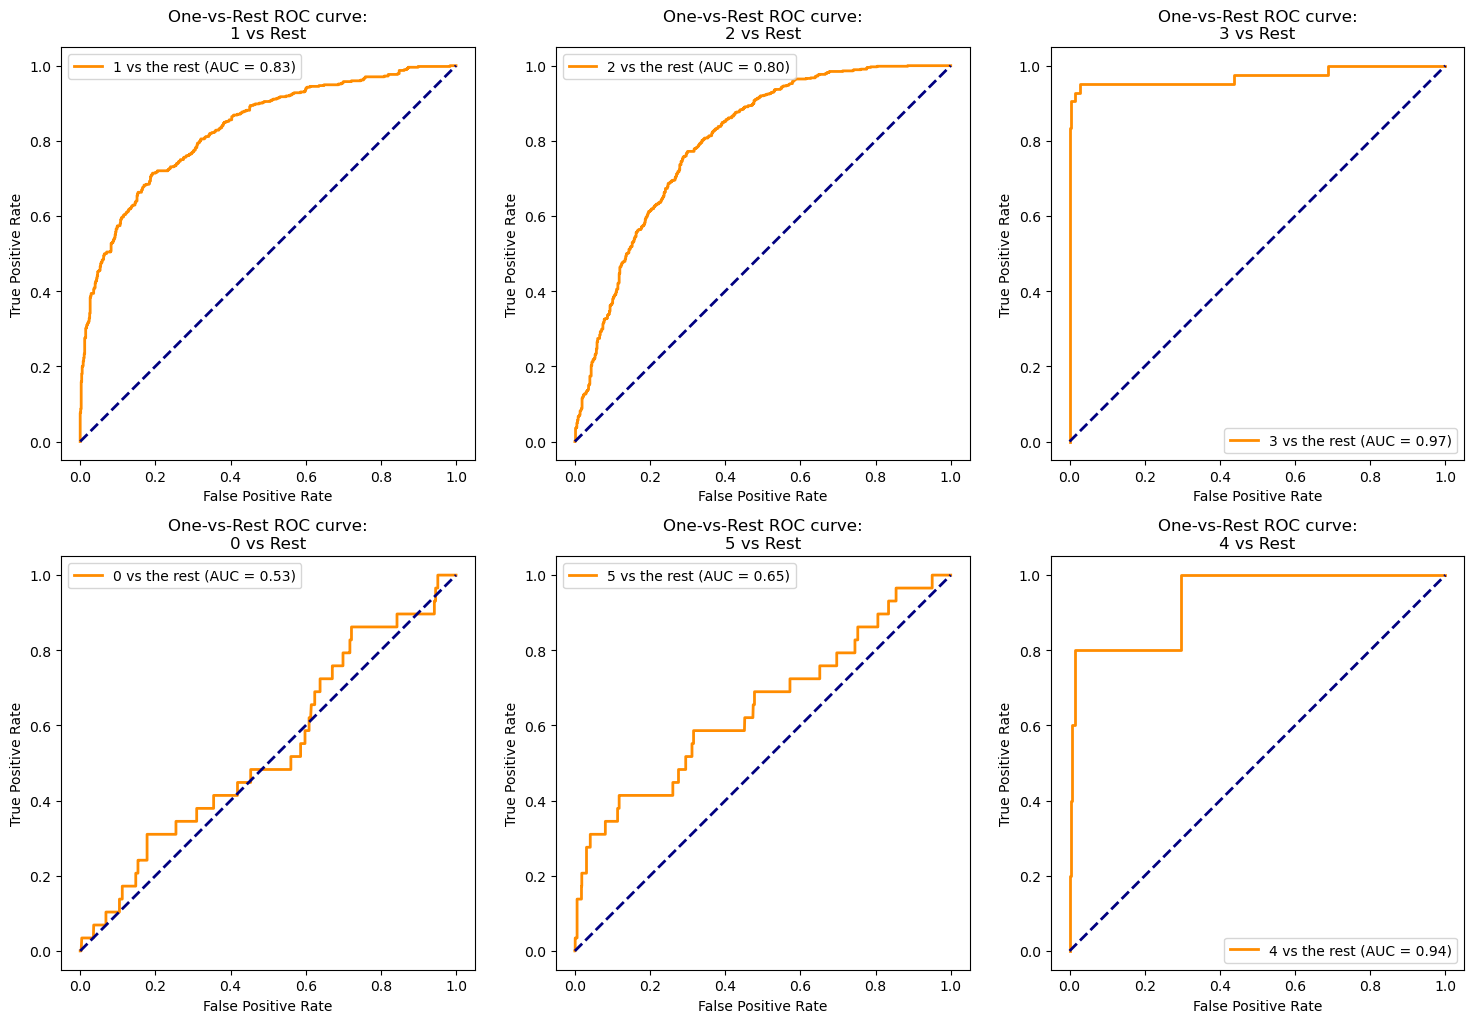

In [48]:
for classifier_name, classifier in classifiers_xgb:
    # ajustar modelo sintonizado con datos de entrenamiento
    classifier.fit(x_train1, y_train1_bin)    

    # crear y_predict vector de predicciones
    y_predict = classifier.predict(x_test1)
    
    # calcular probabilidad de pertenencia a clase
    y_score = classifier.predict_proba(x_test1)
    
    # ROC OnevsRest
    label_binarizer = LabelBinarizer().fit(y_train1_bin)
    y_onehot_test = label_binarizer.transform(y_test1_bin)
    
    # clases en y-target
    clases = y_train1_bin['Status'].unique().tolist()
    
    print("Modelo de Clasificación: "+ str(classifier_name) )
    print("")
    
    # Create subplots
    fig, axes = plt.subplots(nrows=len(clases) // 3 + 1, ncols=3, figsize=(15, 5 * (len(clases) // 3 + 1)))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    
    
    for i, class_of_interest in enumerate(clases):
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

        # ROC OnevsRest
        fpr, tpr, _ = roc_curve(y_onehot_test[:, class_id], y_score[:, class_id])
        roc_auc = auc(fpr, tpr)

        ax = axes[i // 3, i % 3]
        ax.plot(fpr, tpr, color="darkorange", lw=2, label=f"{class_of_interest} vs the rest (AUC = {roc_auc:.2f})")
        ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(f"One-vs-Rest ROC curve:\n{class_of_interest} vs Rest")
        ax.legend(loc="best")
        ax.axis("square")

    # Remove any empty subplots
    for i in range(len(clases), (len(clases) // 3 + 1) * 3):
        fig.delaxes(axes.flatten()[i])

    # Adjust layout
    plt.tight_layout()
    plt.show()



#### Matriz de Confusión

c:\Users\dfoso\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Matriz de Confusión Clasificador: Random Forest


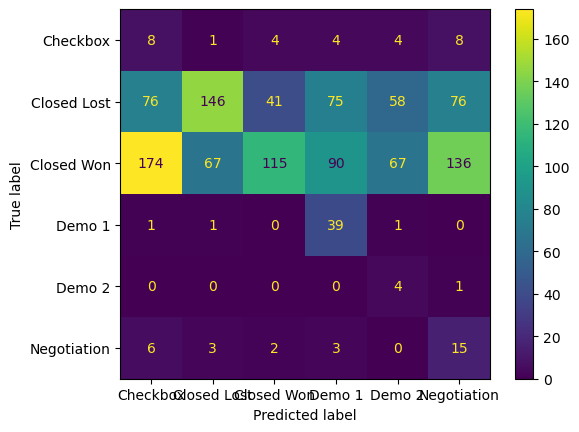

c:\Users\dfoso\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\dfoso\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

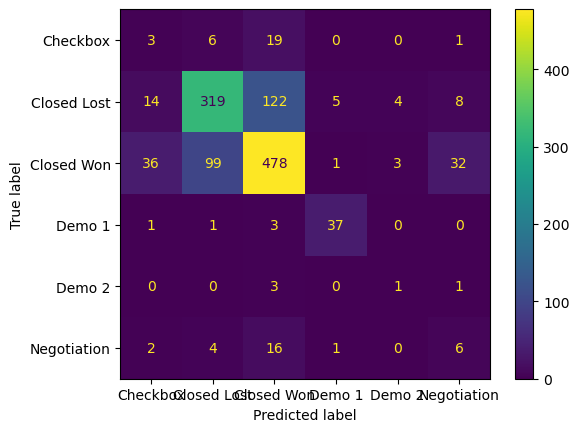

In [24]:
for classifier_name, classifier in classifiers:
    
    # ajustar modelo sintonizado con datos de entrenamiento
    classifier.fit(x_train1, y_train1)    
    
    # crear y_predict vector de predicciones
    y_predict = classifier.predict(x_test1)
    
    # calcular probabilidad de pertenencia a clase
    y_score = classifier.predict_proba(x_test1)
    
    # calcular matriz de confusion
    confusion = confusion_matrix(y_test1, y_predict) 
    classifier_confusion.append(confusion)    
    
    print('Matriz de Confusión Clasificador: '+ str(classifier_name))
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion,
                               display_labels=classifier.classes_)
    disp.plot()
    plt.show()

[16:05:08] ======== Monitor (0): HostSketchContainer ========
[16:05:08] AllReduce: 0.000328s, 1 calls @ 328us

[16:05:08] MakeCuts: 0.000359s, 1 calls @ 359us

[16:05:08] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0


c:\Users\dfoso\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:05:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\dfoso\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:05:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[16:05:10] ======== Monitor (0): Learner ========
[16:05:10] Configure: 0.001105s, 1 calls @ 1105us

[16:05:10] EvalOneIter: 0.004471s, 300 calls @ 4471us

[16:05:10] GetGradient: 0.168503s, 300 calls @ 168503us

[16:05:10] PredictRaw: 0.000466s, 300 calls @ 466us

[16:05:10] UpdateOneIter: 1.97349s, 300 calls @ 1973495us

[16:05:10] ======== Monitor (0): GBTree ========
[16:05:10] BoostNewTrees: 1.80112s, 300 calls @ 1801123us

[16:05:10] CommitModel: 0.000244s, 300 calls @ 244us

[16:05:10] ======== Monitor (0): HistUpdater ========
[16:05:10] BuildHistogram: 0.523325s, 14838 calls @ 523325us

[16:05:10] EvaluateSplits: 0.39976s, 16638 calls @ 399760us

[16:05:10] InitData: 0.039648s, 1800 calls @ 39648us

[16:05:10] InitRoot: 0.301004s, 1800 calls @ 301004us

[16:05:10] LeafPartition: 0.0002s, 1800 calls @ 200us

[16:05:10] UpdatePosition: 0.339044s, 15388 calls @ 339044us

[16:05:10] UpdatePredictionCache: 0.03889s, 1800 calls @ 38890us

[16:05:10] UpdateTree: 1.69604s, 1800 calls 

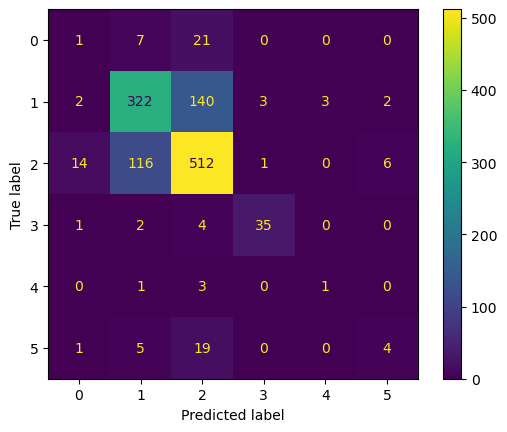

In [50]:
for classifier_name, classifier in classifiers_xgb:
    
    # ajustar modelo sintonizado con datos de entrenamiento
    classifier.fit(x_train1, y_train1_bin)    
    
    # crear y_predict vector de predicciones
    y_predict = classifier.predict(x_test1)
    
    # calcular probabilidad de pertenencia a clase
    y_score = classifier.predict_proba(x_test1)
    
    # calcular matriz de confusion
    confusion = confusion_matrix(y_test1_bin, y_predict) 
    classifier_confusion_xgb.append(confusion)    
    
    print('Matriz de Confusión Clasificador: '+ str(classifier_name))
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion,
                               display_labels=classifier.classes_)
    disp.plot()
    plt.show()
    

#### Métricas de evaluación: Clasificación Multiclase

In [27]:
for classifier_name, classifier in classifiers:

    # ajustar modelo sintonizado con datos de entrenamiento
    classifier.fit(x_train1, y_train1)    
    
    # crear y_predict vector de predicciones
    y_predict = classifier.predict(x_test1)
    
    # calcular probabilidad de pertenencia a clase
    y_score = classifier.predict_proba(x_test1)
    
    # calcular matriz de confusión
    confusion = confusion_matrix(y_test1, y_predict) 
    
    n_classes = len(y_train1['Status'].unique().tolist() )
    
    for i in range(n_classes):
        tp = confusion[i, i]
        fn = sum(confusion[i, :]) - tp
        fp = sum(confusion[:, i]) - tp
        tn = sum(sum(confusion)) - tp - fn - fp
        
    classes = y_train1['Status'].unique().tolist()

    
    # calcular métricas de evaluación para clasificación
    acc = accuracy_score(y_test1,y_predict)
    
    
    f1_micro = f1_score(y_test1,y_predict, average='micro')
    f1_macro = f1_score(y_test1,y_predict, average='macro')
    f1_weighted = f1_score(y_test1,y_predict, average='weighted')
    
    
    recall_micro = recall_score(y_test1,y_predict, average='micro')
    recall_macro = recall_score(y_test1,y_predict, average='macro')
    recall_weighted = recall_score(y_test1,y_predict, average='weighted')
    
    precision_micro = precision_score(y_test1,y_predict, average='micro')
    precision_macro = precision_score(y_test1,y_predict, average='macro')
    precision_weighted = precision_score(y_test1,y_predict, average='weighted')
    
    spec = tn/(tn+fp)
    
    
    balanced_acc = balanced_accuracy_score(y_test1,y_predict)
    cohen_kappa = cohen_kappa_score(y_test1,y_predict, labels=classes)
    matthews_corr = matthews_corrcoef(y_test1,y_predict)
    top_k = top_k_accuracy_score(y_test1, y_score )
    
    
    # agregar métricas a listas 
    classifier_acc.append(acc)

    classifier_recall_micro.append(recall_micro)
    classifier_recall_macro.append(recall_macro)
    classifier_recall_weighted.append(recall_weighted)

    classifier_spec.append(spec)

    classifier_precision_micro.append(precision_micro)
    classifier_precision_macro.append(precision_macro)
    classifier_precision_weighted.append(precision_weighted)

    classifier_f1_micro.append(f1_micro)
    classifier_f1_macro.append(f1_macro)
    classifier_f1_weighted.append(f1_weighted)
    
    classifier_balanced_acc.append(balanced_acc)
    classifier_cohen_kappa.append(cohen_kappa)
    classifier_matthews_corrcoef.append(matthews_corr)
    classifier_top_k_accuracy.append(top_k)


c:\Users\dfoso\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


c:\Users\dfoso\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\dfoso\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [53]:
for classifier_name, classifier in classifiers_xgb:

    # ajustar modelo sintonizado con datos de entrenamiento
    classifier.fit(x_train1, y_train1_bin)    
    
    # crear y_predict vector de predicciones
    y_predict = classifier.predict(x_test1)
    
    # calcular probabilidad de pertenencia a clase
    y_score = classifier.predict_proba(x_test1)
    
    # calcular matriz de confusión
    confusion = confusion_matrix(y_test1_bin, y_predict) 
    
    n_classes = len(y_train1_bin['Status'].unique().tolist() )
    
    for i in range(n_classes):
        tp = confusion[i, i]
        fn = sum(confusion[i, :]) - tp
        fp = sum(confusion[:, i]) - tp
        tn = sum(sum(confusion)) - tp - fn - fp
        
    classes = y_train1_bin['Status'].unique().tolist()

    
    # calcular métricas de evaluación para clasificación
    acc = accuracy_score(y_test1_bin,y_predict)
    
    
    f1_micro = f1_score(y_test1_bin,y_predict, average='micro')
    f1_macro = f1_score(y_test1_bin,y_predict, average='macro')
    f1_weighted = f1_score(y_test1_bin,y_predict, average='weighted')
    
    
    recall_micro = recall_score(y_test1_bin,y_predict, average='micro')
    recall_macro = recall_score(y_test1_bin,y_predict, average='macro')
    recall_weighted = recall_score(y_test1_bin,y_predict, average='weighted')
    
    precision_micro = precision_score(y_test1_bin,y_predict, average='micro')
    precision_macro = precision_score(y_test1_bin,y_predict, average='macro')
    precision_weighted = precision_score(y_test1_bin,y_predict, average='weighted')
    
    spec = tn/(tn+fp)
    
    
    balanced_acc = balanced_accuracy_score(y_test1_bin,y_predict)
    cohen_kappa = cohen_kappa_score(y_test1_bin,y_predict, labels=classes)
    matthews_corr = matthews_corrcoef(y_test1_bin,y_predict)
    top_k = top_k_accuracy_score(y_test1_bin, y_score )
    
    
    # agregar métricas a listas 
    classifier_acc_xgb.append(acc)

    classifier_recall_micro_xgb.append(recall_micro)
    classifier_recall_macro_xgb.append(recall_macro)
    classifier_recall_weighted_xgb.append(recall_weighted)

    classifier_spec_xgb.append(spec)

    classifier_precision_micro_xgb.append(precision_micro)
    classifier_precision_macro_xgb.append(precision_macro)
    classifier_precision_weighted_xgb.append(precision_weighted)

    classifier_f1_micro_xgb.append(f1_micro)
    classifier_f1_macro_xgb.append(f1_macro)
    classifier_f1_weighted_xgb.append(f1_weighted)
    
    classifier_balanced_acc_xgb.append(balanced_acc)
    classifier_cohen_kappa_xgb.append(cohen_kappa)
    classifier_matthews_corrcoef_xgb.append(matthews_corr)
    classifier_top_k_accuracy_xgb.append(top_k)


[16:07:20] ======== Monitor (0): HostSketchContainer ========
[16:07:20] AllReduce: 0.00038s, 1 calls @ 380us

[16:07:20] MakeCuts: 0.000408s, 1 calls @ 408us

[16:07:20] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0


c:\Users\dfoso\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:07:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\dfoso\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:07:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[16:07:22] ======== Monitor (0): Learner ========
[16:07:22] Configure: 0.001047s, 1 calls @ 1047us

[16:07:22] EvalOneIter: 0.003407s, 300 calls @ 3407us

[16:07:22] GetGradient: 0.16849s, 300 calls @ 168490us

[16:07:22] PredictRaw: 0.000443s, 300 calls @ 443us

[16:07:22] UpdateOneIter: 2.00399s, 300 calls @ 2003991us

[16:07:22] ======== Monitor (0): GBTree ========
[16:07:22] BoostNewTrees: 1.83178s, 300 calls @ 1831779us

[16:07:22] CommitModel: 0.000234s, 300 calls @ 234us

[16:07:22] ======== Monitor (0): HistUpdater ========
[16:07:22] BuildHistogram: 0.581216s, 14838 calls @ 581216us

[16:07:22] EvaluateSplits: 0.434948s, 16638 calls @ 434948us

[16:07:22] InitData: 0.042162s, 1800 calls @ 42162us

[16:07:22] InitRoot: 0.169213s, 1800 calls @ 169213us

[16:07:22] LeafPartition: 0.000211s, 1800 calls @ 211us

[16:07:22] UpdatePosition: 0.408432s, 15388 calls @ 408432us

[16:07:22] UpdatePredictionCache: 0.041291s, 1800 calls @ 41291us

[16:07:22] UpdateTree: 1.73837s, 1800 cal

#### Gráficas

#### Reporte de Clasificación

In [28]:
y_pred_rf= rf_op.predict(x_test1)
print(classification_report(y_test1, y_pred_rf))

              precision    recall  f1-score   support

    Checkbox       0.03      0.28      0.05        29
 Closed Lost       0.67      0.31      0.42       472
  Closed Won       0.71      0.18      0.28       649
      Demo 1       0.18      0.93      0.31        42
      Demo 2       0.03      0.80      0.06         5
 Negotiation       0.06      0.52      0.11        29

    accuracy                           0.27      1226
   macro avg       0.28      0.50      0.21      1226
weighted avg       0.64      0.27      0.33      1226



In [29]:
y_pred_lgbm= lgbm_op.predict(x_test1)
print(classification_report(y_test1, y_pred_lgbm))

[LightGBM] [Warning] Unknown parameter: max_features
              precision    recall  f1-score   support

    Checkbox       0.05      0.10      0.07        29
 Closed Lost       0.74      0.68      0.71       472
  Closed Won       0.75      0.74      0.74       649
      Demo 1       0.84      0.88      0.86        42
      Demo 2       0.12      0.20      0.15         5
 Negotiation       0.12      0.21      0.16        29

    accuracy                           0.69      1226
   macro avg       0.44      0.47      0.45      1226
weighted avg       0.71      0.69      0.70      1226



In [31]:
y_pred_xgb= xgb_op.predict(x_test1)
print(classification_report(y_test1_bin, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.05      0.03      0.04        29
           1       0.71      0.68      0.70       472
           2       0.73      0.79      0.76       649
           3       0.90      0.83      0.86        42
           4       0.25      0.20      0.22         5
           5       0.33      0.14      0.20        29

    accuracy                           0.71      1226
   macro avg       0.50      0.45      0.46      1226
weighted avg       0.70      0.71      0.71      1226



In [54]:
# guardar mejor modelo
joblib.dump(xgb_op, 'data/modelos/shimoku/modelo_top.pkl')   

['data/modelos/shimoku/modelo_top.pkl']